目次  
1.前準備  
2.データ概要の把握  
  
3.顧客マスタの分析  
3.1.基礎統計  
3.2.顧客コード  
3.3.売上履歴の顧客コード  
3.4.性別  
3.5.郵便番号  
3.6.誕生日  
3.7.性別、年齢  
3.8.対象分類商品を購入した顧客  
  
4.商品マスタの分析  
4.1.基礎統計  
4.2.JANCD  
4.3.部門  
4.4.大分類、中分類、小分類  
  
5.売上履歴の分析  
5.1.基礎統計  
5.2.店舗コード  
5.3.レジNo、レシートNo、レシート行  
5.4.日付、時間  
5.5.ジャンコード  
5.6.部門コード  
5.7.数量  
5.8.売単価  
5.9.原単価
5.10.値引  
5.11.販売金額  
5.12.顧客コード  

6.時系列データ分析  
6.1.データ準備  
6.2.ADF検定  
6.3.周期性の分析  

7.相関分析  
7.1.目的変数の生成  
7.2.ペアプロット  
7.3.相関行列  
7.4.２変数の相関分析  

5.検定  
5.1.F検定（等分散生の検定）  
5.2.アンダーサンプリング  
5.3.シャピロ=ウィルク検定（正規性の検定）  
5.4.F検定（アンダーサンプリング後）  
5.5.バートレット検定  
5.6.ルビーン検定  
5.7.考察  

５.まとめ  

# 前準備

In [43]:
from IPython.display import HTML
HTML('''<script>  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide code')
    }
    code_shown= !code_shown
  }
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show code"></form>''')
from IPython.display import Javascript, display
from ipywidgets import widgets
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))
button= widgets.Button(description="Refresh")
button.on_click(run_all)
display(button)

Button(description='Refresh', style=ButtonStyle())

In [44]:
print("ライブラリ群")
print("データ処理系")
import csv
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss

print("描画系")
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
from matplotlib import rcParams
import japanize_matplotlib
mplstyle.use('fast')
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')

print("表示調整系")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
pd.options.display.float_format = '{:.0f}'.format
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["font.size"] = 10
from IPython.core.display import display, HTML
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from tqdm import tqdm # プログレスバー表示用

ライブラリ群
データ処理系
描画系
表示調整系


In [45]:
print('データ取得')
items = pd.read_csv("./mst_items.csv")
customers = pd.read_csv("./mst_customers.csv")
sales_3121 = pd.read_csv("./sales_3121.csv")
sales_3122 = pd.read_csv("./sales_3122.csv");

データ取得


# データの概要把握

In [46]:
print('レコード件数比較用の関数')
def show_graph(labels, records, color, va):
    graph = plt.bar(labels, records, color=color)

    def autolabel(graph):
        for rect in graph:
            labels = rect.get_height()
            plt.annotate('{}'.format(labels),
                xy=(rect.get_x() + rect.get_width() / 2, labels),
                xytext=(0, 4),
                textcoords="offset points",
                ha='center', va=va)

    plt.grid()
    autolabel(graph);

レコード件数比較用の関数


レコード件数をプロット


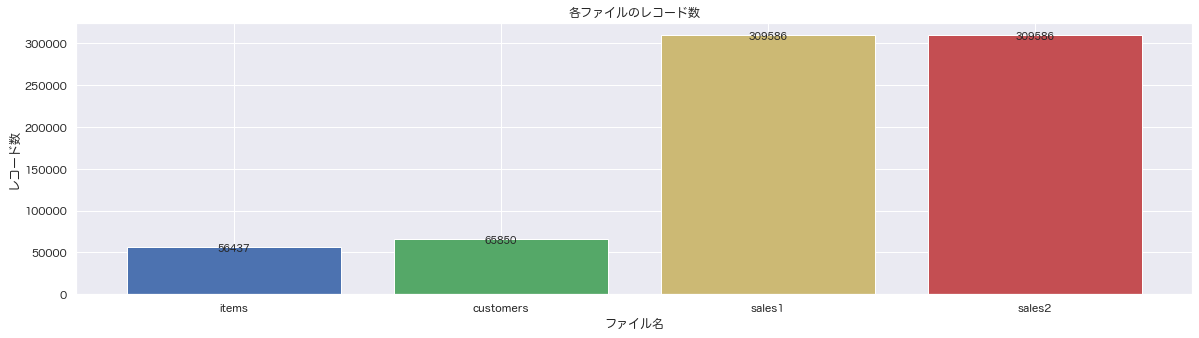

In [47]:
print('レコード件数をプロット')
x1=len(items)
x2=len(customers)
x3=len(sales_3121)
x4=len(sales_3122)
records=[x1,x2,x3,x4]
labels=['items','customers','sales1','sales2']
color=['b','g','y','r']
va='top'

plt.title('各ファイルのレコード数')
plt.xlabel('ファイル名')
plt.ylabel('レコード数')
show_graph(labels, records, color, va);

カラム数をプロット


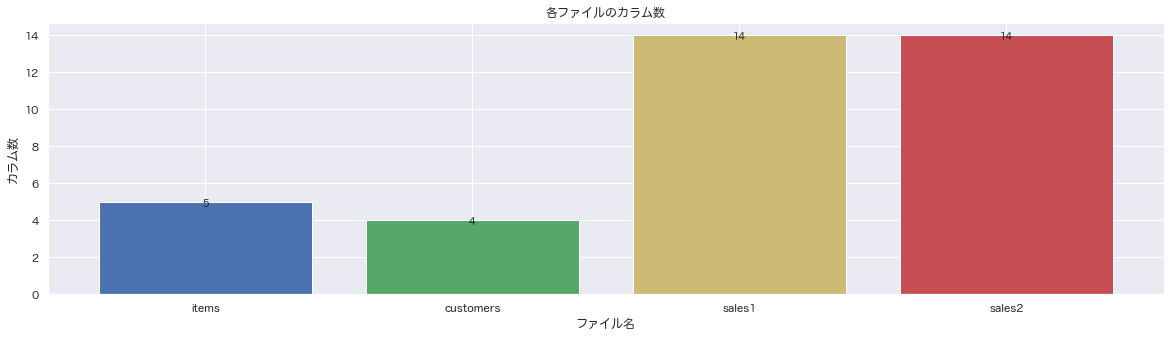

In [48]:
print('カラム数をプロット')
x1=len(items.columns)
x2=len(customers.columns)
x3=len(sales_3121.columns)
x4=len(sales_312２.columns)
records=[x1,x2,x3,x4]
labels=['items','customers','sales1','sales2']
color=['b','g','y','r']
va='top'

plt.title('各ファイルのカラム数')
plt.xlabel('ファイル名')
plt.ylabel('カラム数')
show_graph(labels, records, color, va);

In [49]:
print("欠損値の確認")
missing_columns_customers = pd.DataFrame()
for column in customers.columns:
    missing_columns_customers[column] = [customers[customers[column].isnull()].shape[0]]

missing_columns_items = pd.DataFrame()
for column in items.columns:
    missing_columns_items[column] = [items[items[column].isnull()].shape[0]]
    
missing_columns_sales_3121 = pd.DataFrame()
for column in sales_3121.columns:
    missing_columns_sales_3121[column] = [sales_3121[sales_3121[column].isnull()].shape[0]]
    
missing_columns_sales_3122 = pd.DataFrame()
for column in sales_3122.columns:
    missing_columns_sales_3122[column] = [sales_3122[sales_3122[column].isnull()].shape[0]]

missing_columns_customers
missing_columns_items
missing_columns_sales_3121
missing_columns_sales_3122

欠損値の確認


,顧客コード,性別,郵便番号,誕生日
0,0,0,0,3


,JANCD,部門,大分類,中分類,小分類
0,0,0,0,0,0


,店舗コード,レジNo,レシートNo,日付,時間,レシート行,ジャンコード,部門コード,数量,売単価,値引,販売金額,原単価,顧客コード
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,店舗コード,レジNo,レシートNo,日付,時間,レシート行,ジャンコード,部門コード,数量,売単価,値引,販売金額,原単価,顧客コード
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
print("重複行の確認")
duplicated_check = pd.DataFrame()
duplicated_check["商品マスタ"] = [items[items.duplicated()].shape[0]]
duplicated_check["顧客マスタ"] = [customers[customers.duplicated()].shape[0]]
duplicated_check["売上履歴1"] = [sales_3121[sales_3121.duplicated()].shape[0]]
duplicated_check["売上履歴2"] = [sales_3122[sales_3122.duplicated()].shape[0]]
duplicated_check

重複行の確認


,商品マスタ,顧客マスタ,売上履歴1,売上履歴2
0,0,0,0,0


顧客マスタの誕生日のみ、欠損値あり。  
重複行はなし。  

# 顧客マスタの分析

## データ確認

In [51]:
customers.head()

,顧客コード,性別,郵便番号,誕生日
0,4010001822,2,780-0085,1977
1,4010004361,1,780-0022,1963
2,4010008156,2,780-0963,1974
3,4010025151,2,781-5106,1973
4,4010030084,2,780-0022,1981


## 基礎統計値

In [52]:
print('customers')
join = pd.DataFrame(customers.isnull().sum(axis=0), columns=['欠損値数'])
join['データ型'] = customers.dtypes.values
join['最大値'] = customers.max().values
join['最小値'] = customers.min().values
join

customers


,欠損値数,データ型,最大値,最小値
顧客コード,0,int64,2040000900159,4010001822
性別,0,int64,3,0
郵便番号,0,object,988-0562,000-0000
誕生日,3,float64,2040,0


## 外れ値検出

<AxesSubplot:xlabel='性別'>

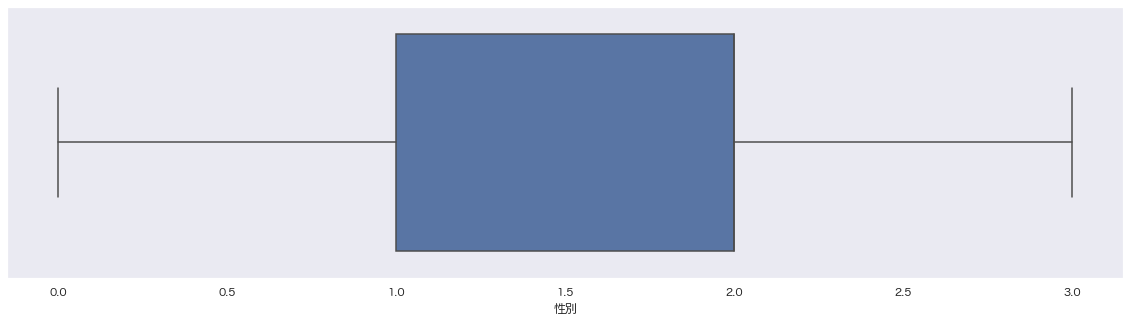

In [53]:
sns.boxplot(x='性別', data=customers)

<AxesSubplot:xlabel='誕生日'>

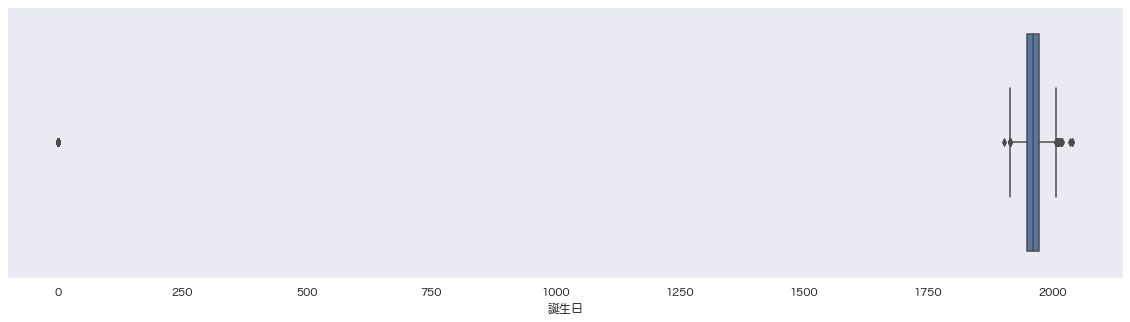

In [54]:
sns.boxplot(x='誕生日', data=customers)

誕生日には、０が登録されている。外れ値だが、未入力に0を当てているものと思われる。

## 顧客コード

In [55]:
print('顧客コードを桁数ごとに集計する')
value_len_list=[]
col_list=[]
for value in tqdm(customers['顧客コード'].astype(str).values):
    col_list.append(value)
    value_len_list.append(len(value))

100%|██████████| 65850/65850 [00:00<00:00, 578301.20it/s]

顧客コードを桁数ごとに集計する


In [56]:
print('描画用関数')
def show_bar_count(labels, records, color, va):
    graph = plt.bar(labels, records, color=color)
    plt.grid()
    for rect in graph:
        labels = rect.get_height()
        plt.annotate(
            '{}'.format(labels),
            xy=(rect.get_x() + rect.get_width() / 2, labels),
            xytext=(0, 2),
            textcoords="offset points",
            ha='center', 
            va=va
        );

描画用関数


In [57]:
print('描画用関数')
def show_plot(df, col_name, top_range, width):
    pd.cut(df[col_name], range(0, top_range, width), right=False).value_counts(sort=False).plot().grid()
    pd.cut(df[col_name], range(0, top_range, width), right=False).value_counts(sort=False).plot.bar().grid();

描画用関数


### 顧客コードの桁数別の登録件数

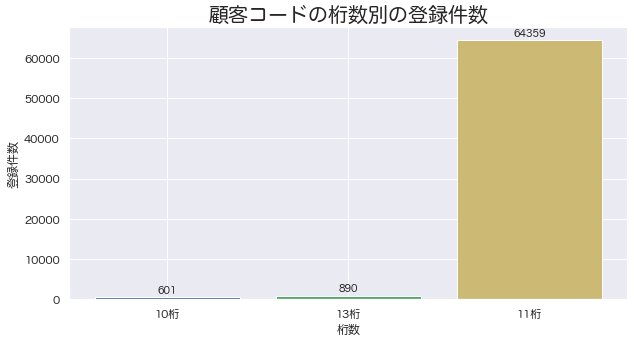

In [58]:
value_len_df = pd.DataFrame(col_list, columns=['顧客コード'])
value_len_df['桁数'] = value_len_list
value_len_count = value_len_df['桁数'].value_counts()
X = value_len_count.index.sort_values().astype(str)
Y = value_len_count.sort_values().values

plt.figure(figsize=(10,5))
plt.title('顧客コードの桁数別の登録件数', fontsize=20)
plt.xlabel('桁数')
plt.ylabel('登録件数')
records=value_len_count.sort_values()
labels=['10桁','13桁','11桁']
color=['b','g','y']
va='bottom'
show_bar_count(labels, records, color, va);

In [59]:
print('顧客コードの概要')
print('桁数ごとにコード値、桁数、登録順番（元データのインデックス）を取得、結合')
len_value = pd.DataFrame()
len_value1 =value_len_df[value_len_df['桁数']==10].iloc[:5]
list1 = len_value1['顧客コード'].tolist()
len_value1['登録順番'] = customers[customers['顧客コード'].isin(list1)].index

len_value2 = value_len_df[value_len_df['桁数']==11].iloc[:5]
list2 = len_value2['顧客コード'].tolist()
len_value2['登録順番'] = customers[customers['顧客コード'].isin(list2)].index

len_value3 = value_len_df[value_len_df['桁数']==13].iloc[:5]
list3 = len_value3['顧客コード'].tolist()
len_value3['登録順番'] = customers[customers['顧客コード'].isin(list3)].index

print('DataFrame Union')
len_value12=len_value1.append(len_value2, ignore_index=True)
len_value123=len_value12.append(len_value3, ignore_index=True)
len_value123

顧客コードの概要
桁数ごとにコード値、桁数、登録順番（元データのインデックス）を取得、結合
DataFrame Union


,顧客コード,桁数,登録順番
0,4010001822,10,0
1,4010004361,10,1
2,4010008156,10,2
3,4010025151,10,3
4,4010030084,10,4
5,10101004702,11,601
6,10101009108,11,602
7,10101010824,11,603
8,10101014818,11,604
9,10101015501,11,605


#### 考察

もしcsvファイルがソートされていないとすれば、10桁→11桁→13桁の順番で登録されており、13桁が新しいコードとなる。  
ソートされてしまっている場合は、10桁→11桁→13桁でなにかしらの顧客属性の区別がある可能性もある。  

### 売上履歴の顧客コード（対比）

In [60]:
print('売上履歴の顧客コードを桁数ごとに集計する')
value_len_list_sale=[]
col_list_sale=[]
for value in tqdm(sales_3121['顧客コード'].astype(str).values):
    col_list_sale.append(value)
    value_len_list_sale.append(len(value));

  0%|          | 0/309586 [00:00<?, ?it/s]

売上履歴の顧客コードを桁数ごとに集計する


100%|██████████| 309586/309586 [00:00<00:00, 616998.98it/s]


In [61]:
print('重複なし')
print('売上履歴の顧客コードを桁数ごとに集計する')
value_len_list_sale_unique=[]
col_list_sale_unique=[]
for value in tqdm(sales_3121['顧客コード'].astype(str).unique()):
    col_list_sale_unique.append(value)
    value_len_list_sale_unique.append(len(value))

print('件数取得')
value_len_unique_df = pd.DataFrame(col_list_sale_unique, columns=['ユニーク顧客コード'])
value_len_unique_df['件数'] = value_len_list_sale_unique
value_len_count_unique = value_len_unique_df['件数'].value_counts()

print('表示用DataFrame作成')
value_len_sale_unique_df = pd.DataFrame()
value_len_sale_unique_df['顧客コードの桁数'] = value_len_count_unique.index
value_len_sale_unique_df['来店実績のある顧客数'] = value_len_count_unique.values
value_len_sale_unique_df

100%|██████████| 31139/31139 [00:00<00:00, 668792.25it/s]

重複なし
売上履歴の顧客コードを桁数ごとに集計する
件数取得
表示用DataFrame作成


,顧客コードの桁数,来店実績のある顧客数
0,11,30331
1,13,500
2,10,306
3,4,1
4,1,1


#### 考察

4桁は誤登録と思われる。  
桁数別に見ると、それぞれ登録件数の約半数が来店している。  

## 性別

### 性別ごとの登録件数

男女件数


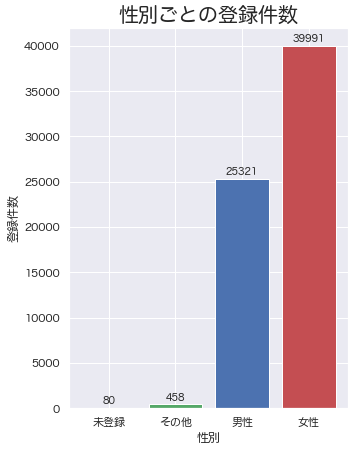

In [62]:
print('男女件数')
sexs = customers['性別']
plt.figure(figsize=[5, 7])
plt.title('性別ごとの登録件数', fontsize=20)
plt.xlabel('性別')
plt.ylabel('登録件数')
records=sexs.value_counts().sort_values()
labels=['未登録','その他','男性', '女性']
color=['y','g','b','r']
va='bottom'
show_bar_count(labels, records, color, va);

#### 考察

0=男性、1=女性で合っているか。 

## 郵便番号

### 都道府県別の件数

In [63]:
print('郵便番号・所在地情報の取得')
import csv

print('初期化')
zipno=[]
zip_rome=[]
shi=[]

print('データ取得')
with open('KEN_ALL_ROME.csv', 'rt', encoding='Shift_JIS') as fp:
    reader = csv.reader(fp)
    for row in reader:
        zipno.append(row[0])
        zip_rome.append(row[1])
        shi.append(row[2])
zipdf = pd.DataFrame()
zipdf['郵便番号'] = zipno
zipdf['都道府県'] = zip_rome
zipdf['市区町村'] = shi

print('郵便番号加工')
customers['郵便番号'] = customers['郵便番号'].str.replace('-','')
zipcd = customers['郵便番号']

print('都道府県、市区町村結合')
customers_join = pd.DataFrame()
customers_join = pd.merge(customers, zipdf, on='郵便番号', how='left')
customers_join['都道府県'] = customers_join['都道府県'].fillna('不明');

郵便番号・所在地情報の取得
初期化
データ取得
郵便番号加工
都道府県、市区町村結合


所在地情報の取得
不明住所補完
都道府県番号の結合
住所情報をプロット
都道府県数： 31


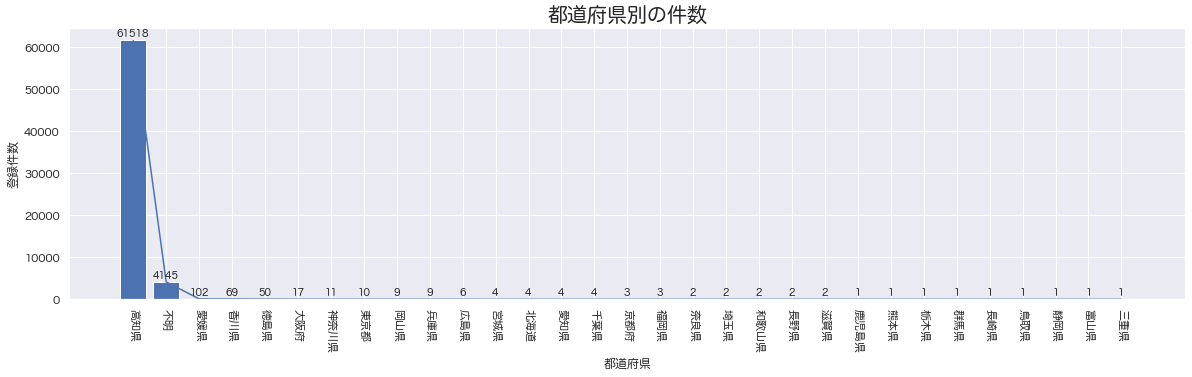

In [64]:
print('所在地情報の取得')
zip_list=[]
with open('./ALL_KEN.csv', 'rt') as fp:
    reader = csv.reader(fp)
    for row in reader:
        zip_list.append(row[0])

print('不明住所補完')
zip_df = pd.DataFrame()
zip_df['都道府県'] = zip_list
zip_df['都道府県番号'] = zip_df.index + 1
zip_df = zip_df.append({'都道府県': '不明', '都道府県番号': 48}, ignore_index=True)

print('都道府県番号の結合')
customers_join_no = pd.DataFrame()
customers_join_no = pd.merge(customers_join, zip_df, on='都道府県', how='left')
ken_counts = customers_join_no['都道府県'].value_counts(sort=True)

print('住所情報をプロット')
labels=ken_counts.index
records=ken_counts.values
color=['b']
va='bottom'
plt.xticks(rotation=-90)
plt.title('都道府県別の件数', fontsize=20)
plt.xlabel('都道府県')
plt.ylabel('登録件数')
show_bar_count(labels, records, color, va)
plt.plot(records)
print(f'都道府県数： {ken_counts.shape[0]}');

### 市区町村別の件数

市区町村数： 31


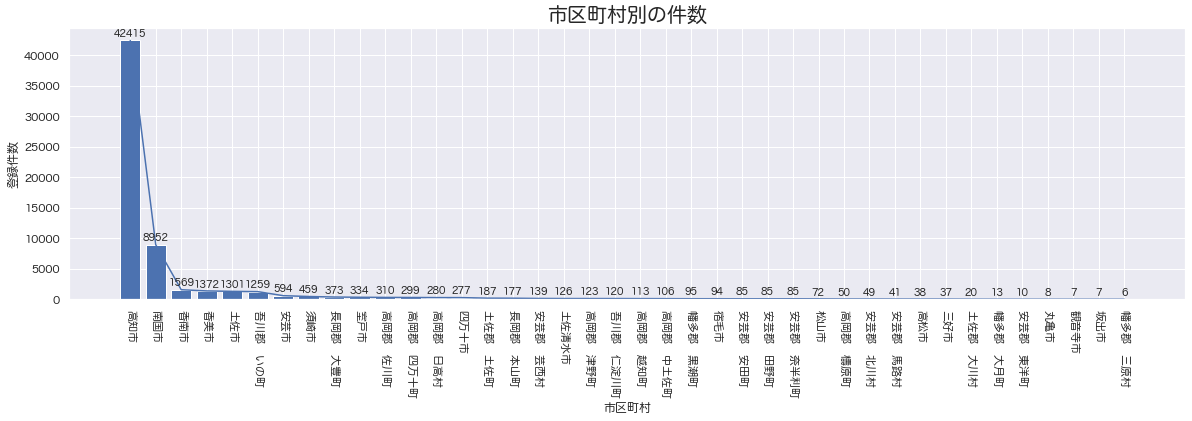

In [65]:
shi_count = customers_join_no['市区町村'].value_counts(sort=True)
shi_counts = shi_count[shi_count.values>5]

labels=shi_counts.index
records=shi_counts.values
color=['b']
va='bottom'
plt.xticks(rotation=-90)
plt.title('市区町村別の件数', fontsize=20)
plt.xlabel('市区町村')
plt.ylabel('登録件数')
show_bar_count(labels, records, color, va)
plt.plot(records)
print(f'市区町村数： {ken_counts.shape[0]}');

#### 考察

不明4145件は、郵便番号のユニーク数は12件、どれも現在は廃止された郵便番号であり、高知県高知市に合併されている。  
全体の99%は高知県に属している。   
残り1%の大半も、愛媛、香川、徳島と四国が大半である。  
市区町村別では、高知県が全体の69%（不明件数も含めると75%）となり、大半を占めている。  

## 誕生日

### 年代別の件数

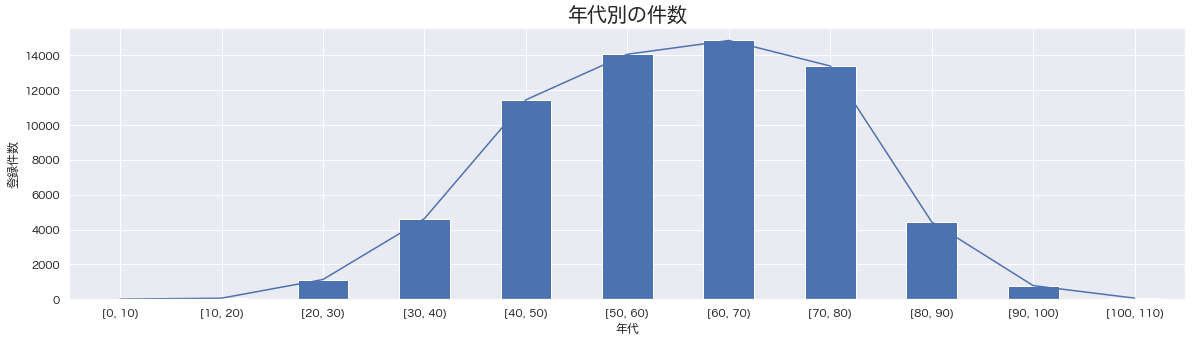

In [66]:
birthdays = customers['誕生日']
customers['年齢'] = 2021 - birthdays
ages = customers['年齢']

plt.title('年代別の件数', fontsize=20)
plt.xlabel('年代')
plt.ylabel('登録件数')
pd.cut(ages, range(0, 111, 10), right=False).value_counts(sort=False).plot.bar().grid()
pd.cut(ages, range(0, 111, 10), right=False).value_counts(sort=False).plot().grid();

#### 考察

４０〜７０代の顧客が大半である。  

## 性別、年齢

### 年代と性別ごとの件数

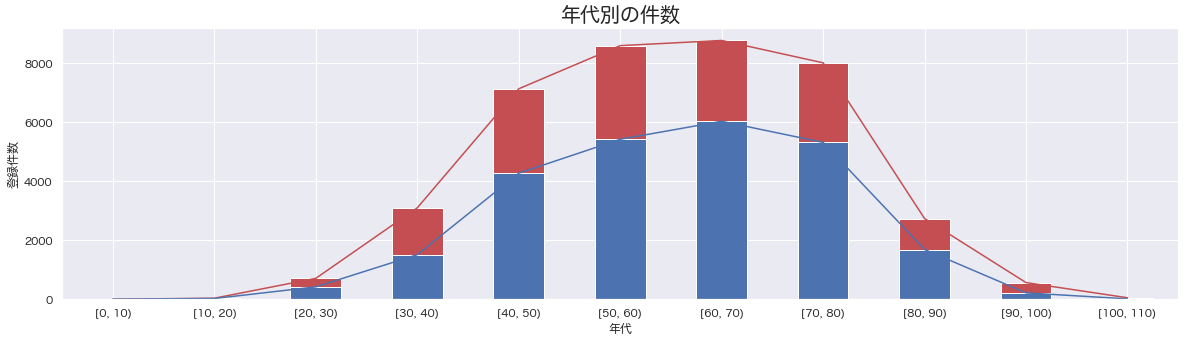

In [67]:
x = customers[ (customers['性別']==1) & (customers['性別'].isnull()==False) ]['年齢']
y = customers[ (customers['性別']==2) & (customers['性別'].isnull()==False) ]['年齢']

plt.title('年代別の件数', fontsize=20)
plt.xlabel('年代')
plt.ylabel('登録件数')
pd.cut(y, range(0, 111, 10), right=False).value_counts(sort=False).plot.bar(color='r').grid()
pd.cut(x, range(0, 111, 10), right=False).value_counts(sort=False).plot.bar(color='b').grid()
pd.cut(y, range(0, 111, 10), right=False).value_counts(sort=False).plot(color='r').grid()
pd.cut(x, range(0, 111, 10), right=False).value_counts(sort=False).plot(color='b').grid();

#### 考察

全年代で女性が優位

## 対象分類の商品を購入した顧客

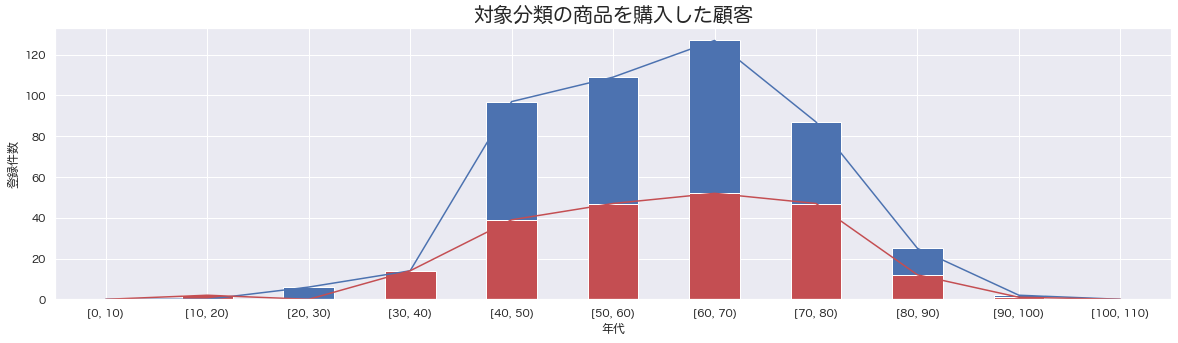

In [68]:
target_customers = pd.read_csv("./past_target_class_customers.csv" )
target_customers_join = pd.merge(target_customers, customers, on='顧客コード', how='left')

plt.title('対象分類の商品を購入した顧客', fontsize=20)
plt.xlabel('年代')
plt.ylabel('登録件数')
x = target_customers_join[ (target_customers_join['性別']==1) & (target_customers_join['性別'].isnull()==False) ]['年齢']
y = target_customers_join[ (target_customers_join['性別']==2) & (target_customers_join['性別'].isnull()==False) ]['年齢']
pd.cut(x, range(0, 111, 10), right=False).value_counts(sort=False).plot.bar(color='b').grid()
pd.cut(y, range(0, 111, 10), right=False).value_counts(sort=False).plot.bar(color='r').grid()
pd.cut(x, range(0, 111, 10), right=False).value_counts(sort=False).plot(color='b').grid()
pd.cut(y, range(0, 111, 10), right=False).value_counts(sort=False).plot(color='r').grid();

#### 考察

対象分類の商品は、男性の方が購入者が多い。  
特に４０〜７０代の数が多い。  

# 商品マスタの分析

## データ確認

In [69]:
items.head()

,JANCD,部門,大分類,中分類,小分類
0,29308,2,27,5,1
1,30786,9,10,15,85
2,30809,9,10,15,85
3,30908,9,10,15,85
4,31035,9,10,15,85


## 基礎統計値

In [70]:
join = pd.DataFrame(items.isnull().sum(axis=0), columns=['欠損値数'])
join['データ型'] = items.dtypes.values
join['最大値'] = items.max().values
join['最小値'] = items.min().values
join['平均値'] = items.mean().values
join['中央値'] = items.median().values
join

,欠損値数,データ型,最大値,最小値,平均値,中央値
JANCD,0,int64,9416922000645,29308,4811474556226,4960126214346
部門,0,int64,30,1,7,6
大分類,0,int64,93,1,23,12
中分類,0,int64,98,1,20,10
小分類,0,int64,98,1,35,15


## 外れ値検出

<AxesSubplot:xlabel='部門'>

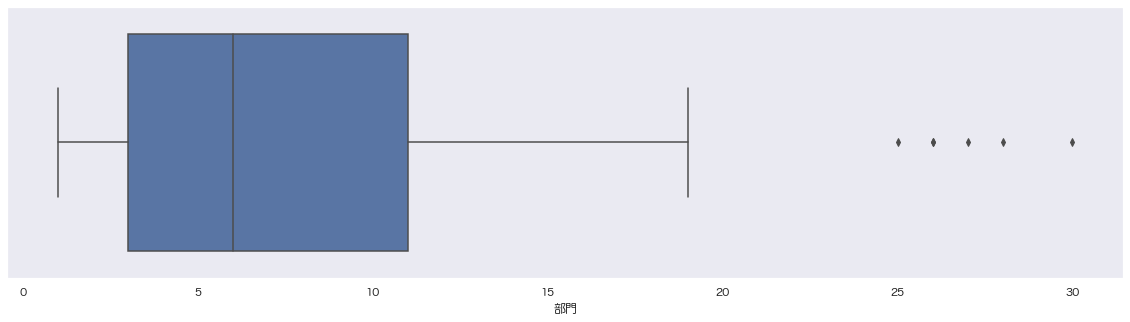

In [71]:
sns.boxplot(x='部門', data=items)

<AxesSubplot:xlabel='大分類'>

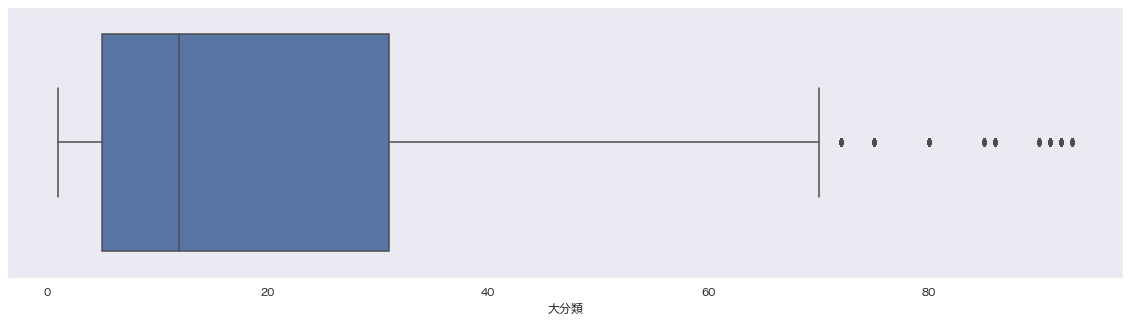

In [72]:
sns.boxplot(x='大分類', data=items)

<AxesSubplot:xlabel='中分類'>

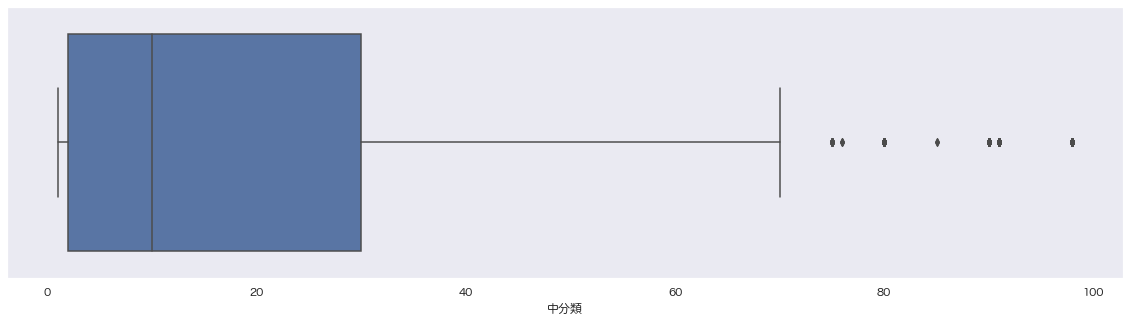

In [73]:
sns.boxplot(x='中分類', data=items)

<AxesSubplot:xlabel='小分類'>

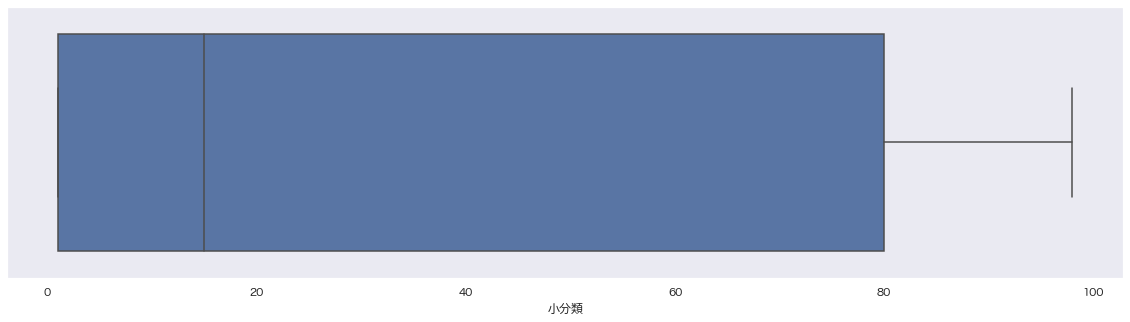

In [74]:
sns.boxplot(x='小分類', data=items)

件数が少ない部門、分類が存在するが、実際に存在しえそうな値であり、ご登録などの異常値ではなさそう。

## JANCD

In [75]:
print('桁数別にデータを取得する関数')
def slice_df(df, col_name, over, under):
    df = items[ (df[col_name] > 10**over) & (df[col_name] < 10**under )][col_name]
    return df

桁数別にデータを取得する関数


In [76]:
print('桁数ごとにジャンコードを取得')
df5=slice_df(items, 'JANCD', 4, 5) # 5桁
df8=slice_df(items, 'JANCD', 7, 8) # 8桁
df9=slice_df(items, 'JANCD', 8, 9) # 9桁
df11=slice_df(items, 'JANCD', 10, 11) # 11桁
df12=slice_df(items, 'JANCD', 11, 12) # 12桁
df13=slice_df(items, 'JANCD', 12, 13); # 13桁

桁数ごとにジャンコードを取得


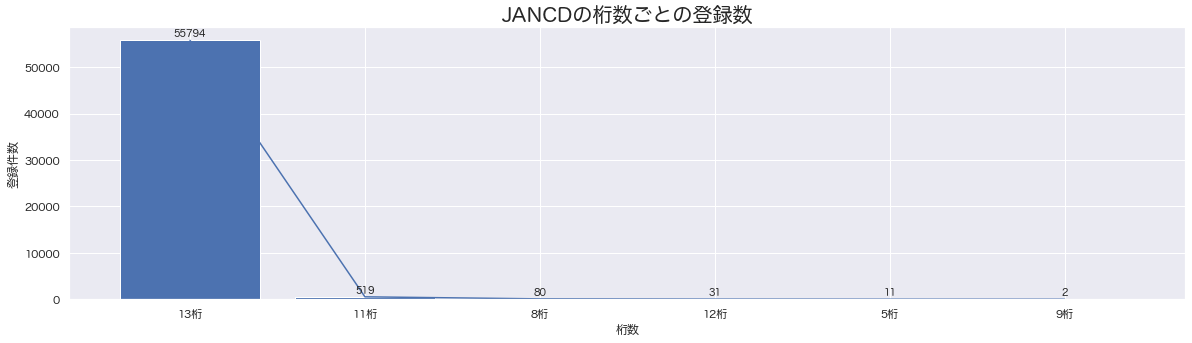

In [77]:
print('')
jancd_cnt = [df13.shape[0], df11.shape[0], df8.shape[0], df12.shape[0], df5.shape[0], df9.shape[0]]
labels = ['13桁','11桁','8桁','12桁','5桁','9桁']
color=['b']
va='bottom'

plt.figure(figsize=[20, 5])
plt.title('JANCDの桁数ごとの登録数', fontsize=20)
plt.xlabel('桁数')
plt.ylabel('登録件数')
show_bar_count(labels, jancd_cnt, color, va)
plt.plot(jancd_cnt);

#### 考察

99% は１３桁

## 部門

### 集計

部門数： 20


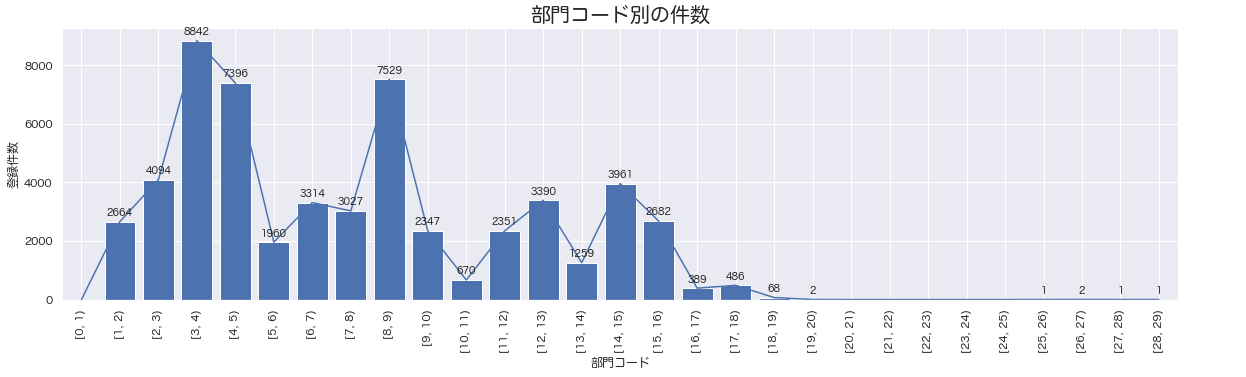

In [78]:
department = items['部門'].value_counts(sort=True)

show_plot(items, '部門', 30, 1);

labels=department.index
records=department.values
color=['b']
va='bottom'
plt.grid()
plt.title('部門コード別の件数', fontsize=20)
plt.xlabel('部門コード')
plt.ylabel('登録件数')
show_graph(labels, records, color, va)
print(f'部門数： {len(department.value_counts())}');

#### 考察

対象の部門（No.4(第３位)）は、7396（全体の13%）

## 大分類、中分類、小分類

In [79]:
print('表示サイズ調整')
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["font.size"] = 10

表示サイズ調整


### 集計（大分類）

大分類数： 48


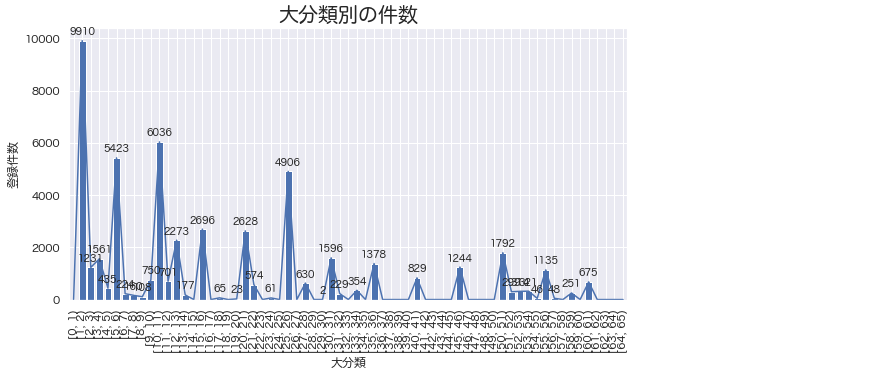

In [80]:
department = items['大分類'].value_counts(sort=True)

show_plot(items, '大分類', 66, 1);

labels=department.index
records=department.values
color=['b']
va='bottom'
plt.grid()
plt.title('大分類別の件数', fontsize=20)
plt.xlabel('大分類')
plt.ylabel('登録件数')
show_graph(labels, records, color, va)
print(f'大分類数： {len(department.value_counts())}');

### 集計（中分類）

中分類数： 51


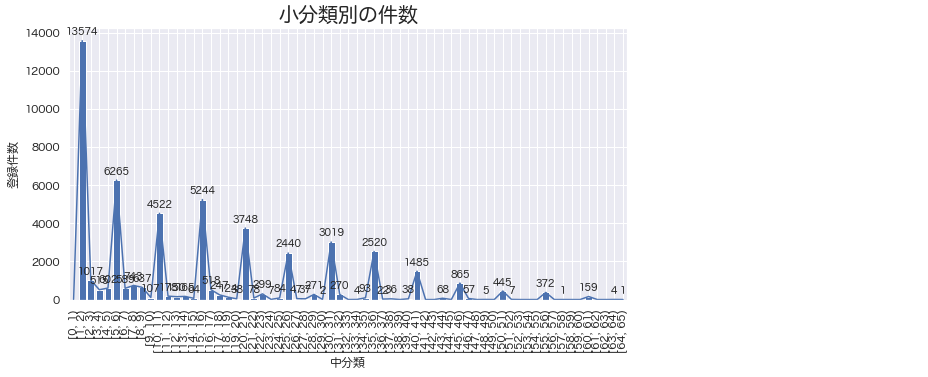

In [81]:
department = items['中分類'].value_counts(sort=True)

show_plot(items, '中分類', 66, 1);

labels=department.index
records=department.values
color=['b']
va='bottom'
plt.grid()
plt.title('小分類別の件数', fontsize=20)
plt.xlabel('中分類')
plt.ylabel('登録件数')
show_graph(labels, records, color, va)
print(f'中分類数： {len(department.value_counts())}');

### 集計（小分類）

小分類数： 50


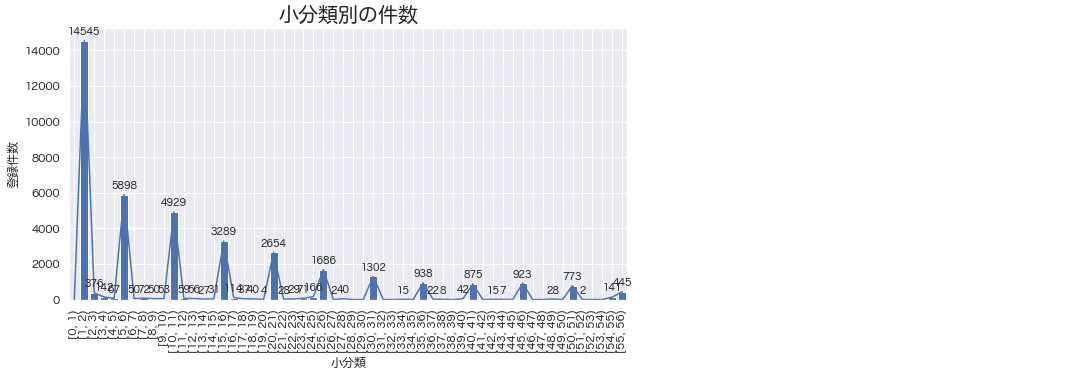

In [82]:
department = items['小分類'].value_counts(sort=True)

show_plot(items, '小分類', 57, 1);

labels=department.index
records=department.values
color=['b']
va='bottom'
plt.grid()
plt.title('小分類別の件数', fontsize=20)
plt.xlabel('小分類')
plt.ylabel('登録件数')
show_graph(labels, records, color, va)
print(f'小分類数： {len(department.value_counts())}');

#### 考察

- 大分類
対象の大分類（No.11）は、701（全体の1%）
- 中分類
対象の部門（No.1,2）は、12591（全体の22%）
- 小分類
小分類=1が第１位(26%)

In [83]:
print('表示サイズ再調整')
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["font.size"] = 10

表示サイズ再調整


# 売上履歴の分析

※売上の変化量・推移の確認は、時系列データ分析の章で実施する。

## データ確認

In [84]:
sales_3121.head()
sales_3122.head()

,店舗コード,レジNo,レシートNo,日付,時間,レシート行,ジャンコード,部門コード,数量,売単価,値引,販売金額,原単価,顧客コード
0,3122,2,7279,20190401,720,1,4974305211712,8,1,3280,0,3280,2086,10509156684
1,3122,2,7279,20190401,720,2,4902111752976,8,1,698,0,698,431,10509156684
2,3122,2,7281,20190401,746,1,4549077898944,7,1,628,0,628,364,10553152729
3,3122,2,7281,20190401,746,2,4971275785045,7,1,1780,0,1780,1070,10553152729
4,3122,2,7282,20190401,758,1,4909622732374,2,1,158,0,158,114,10501100530


,店舗コード,レジNo,レシートNo,日付,時間,レシート行,ジャンコード,部門コード,数量,売単価,値引,販売金額,原単価,顧客コード
0,3122,2,7279,20190401,720,1,4974305211712,8,1,3280,0,3280,2086,10509156684
1,3122,2,7279,20190401,720,2,4902111752976,8,1,698,0,698,431,10509156684
2,3122,2,7281,20190401,746,1,4549077898944,7,1,628,0,628,364,10553152729
3,3122,2,7281,20190401,746,2,4971275785045,7,1,1780,0,1780,1070,10553152729
4,3122,2,7282,20190401,758,1,4909622732374,2,1,158,0,158,114,10501100530


## 基礎統計値

In [85]:
print('sales_3121')
join = pd.DataFrame(sales_3121.isnull().sum(axis=0), columns=['欠損値数'])
join['データ型'] = sales_3121.dtypes.values
join['最大値'] = sales_3121.max().values
join['最小値'] = sales_3121.min().values
join['平均値'] = sales_3121.mean().values
join['中央値'] = sales_3121.median().values
join

sales_3121


,欠損値数,データ型,最大値,最小値,平均値,中央値
店舗コード,0,int64,3122,3122,3122,3122
レジNo,0,int64,80,1,2,3
レシートNo,0,int64,2212668,1,4959,4920
日付,0,int64,20200131,20190401,20191563,20190826
時間,0,int64,1942,655,1345,1341
レシート行,0,int64,40,1,3,2
ジャンコード,0,int64,9416922000645,0,4531742610001,4907077217361
部門コード,0,int64,30,0,8,8
数量,0,int64,600,-51,1,1
売単価,0,int64,137280,0,817,438


In [86]:
print('sales_3122')
join = pd.DataFrame(sales_3122.isnull().sum(axis=0), columns=['欠損値数'])
join['データ型'] = sales_3122.dtypes.values
join['最大値'] = sales_3122.max().values
join['最小値'] = sales_3122.min().values
join['平均値'] = sales_3122.mean().values
join['中央値'] = sales_3122.median().values
join

sales_3122


,欠損値数,データ型,最大値,最小値,平均値,中央値
店舗コード,0,int64,3122,3122,3122,3122
レジNo,0,int64,80,1,2,3
レシートNo,0,int64,2212668,1,4959,4920
日付,0,int64,20200131,20190401,20191563,20190826
時間,0,int64,1942,655,1345,1341
レシート行,0,int64,40,1,3,2
ジャンコード,0,int64,9416922000645,0,4531742610001,4907077217361
部門コード,0,int64,30,0,8,8
数量,0,int64,600,-51,1,1
売単価,0,int64,137280,0,817,438


## 外れ値検出

<AxesSubplot:xlabel='レジNo'>

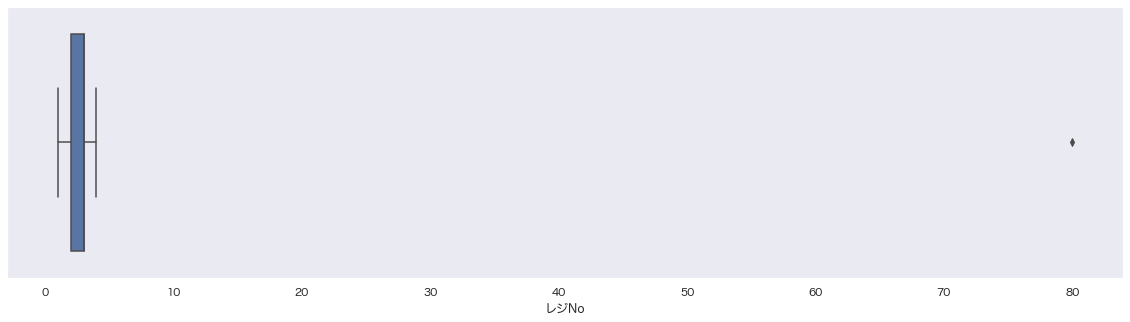

In [87]:
sns.boxplot(x='レジNo', data=sales_3121)

<AxesSubplot:xlabel='数量'>

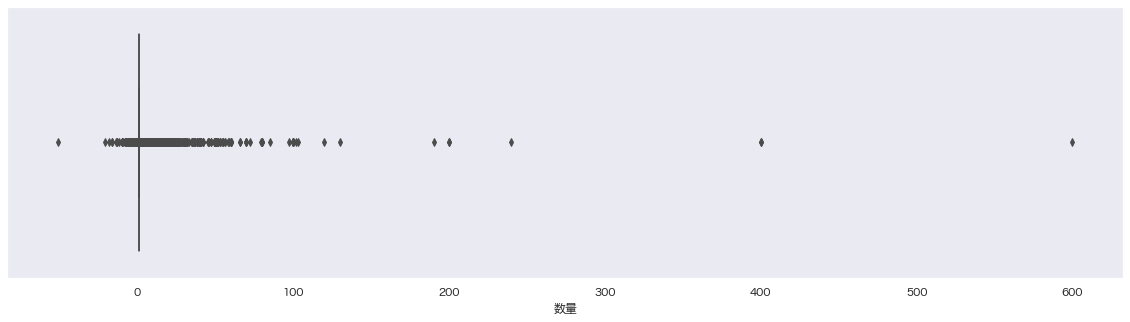

In [88]:
sns.boxplot(x='数量', data=sales_3121)

<AxesSubplot:xlabel='売単価'>

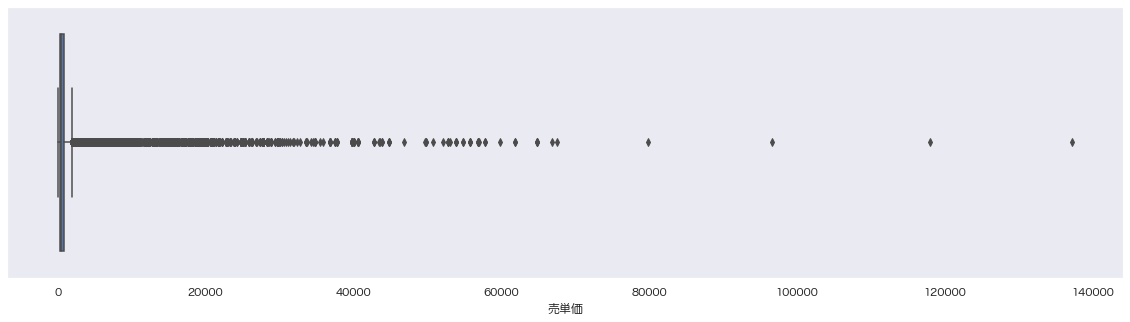

In [89]:
sns.boxplot(x='売単価', data=sales_3121)

<AxesSubplot:xlabel='値引'>

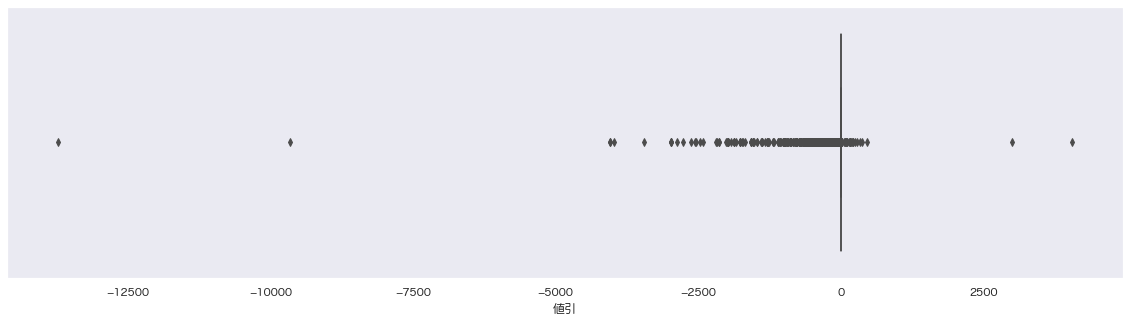

In [90]:
sns.boxplot(x='値引', data=sales_3121)

<AxesSubplot:xlabel='販売金額'>

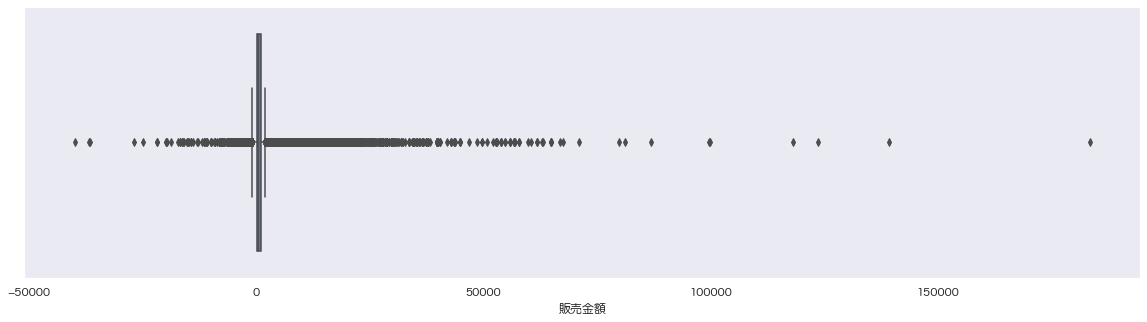

In [91]:
sns.boxplot(x='販売金額', data=sales_3121)

<AxesSubplot:xlabel='原単価'>

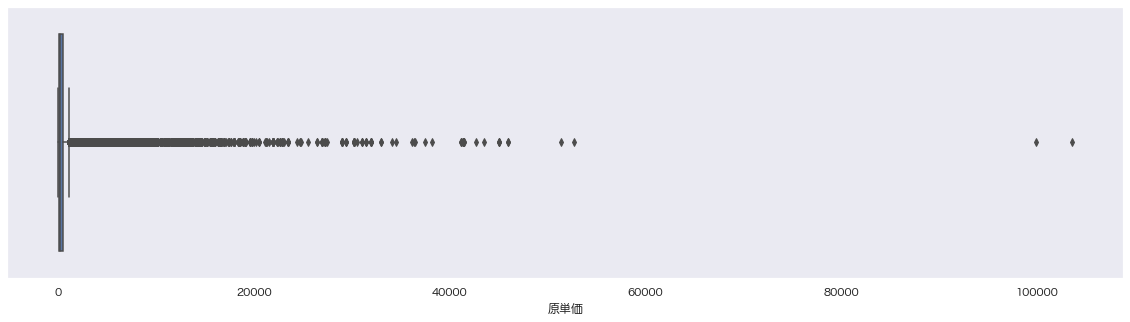

In [92]:
sns.boxplot(x='原単価', data=sales_3121)

突出した値は存在する。実際に存在しえる値の為、学習時は閾値を決めて除外する。

## 店舗コード

In [93]:
print('重複確認')
sales_3121['店舗コード'].unique()
sales_3122['店舗コード'].unique();

重複確認


## レジNo、レシートNo、レシート行

レジ数： 5


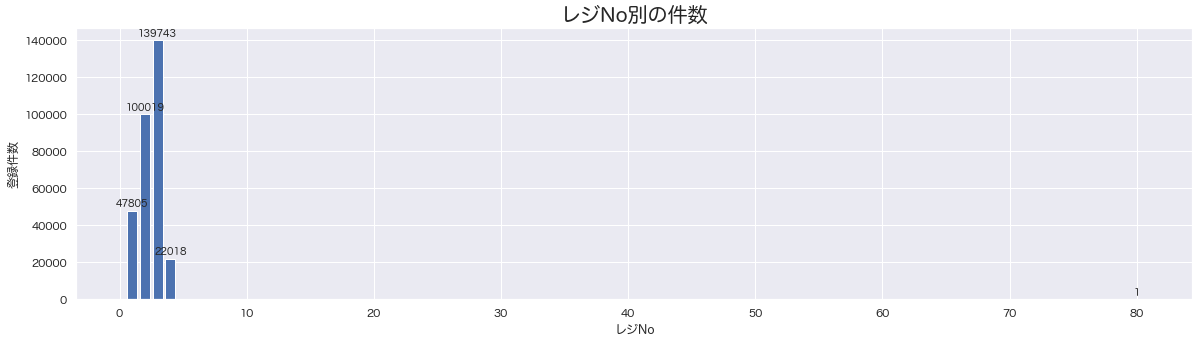

In [94]:
regi_no = sales_3121['レジNo'].value_counts()

labels=regi_no.index
records=regi_no.values
color=['b']
va='bottom'
plt.title('レジNo別の件数', fontsize=20)
plt.xlabel('レジNo')
plt.ylabel('登録件数')
show_bar_count(labels, records, color, va)
print(f'レジ数： {regi_no.shape[0]}');

レシートNo  
1回の買い物につき１つの番号  

レシート行  
1回の買い物につき、商品数分の昇順番号  

## 日付、時間

日付と時間情報  
時間は先頭0埋めが必要  

## ジャンコード

In [95]:
print('ジャンコードを桁数ごとに集計する（sales_3121）')

jancd_list_3121=[]
jancd_len_list_3121=[]
for value in tqdm(sales_3121['ジャンコード'].astype(str).values):
    jancd_list_3121.append(value)
    jancd_len_list_3121.append(len(value));

ジャンコードを桁数ごとに集計する（sales_3121）


100%|██████████| 309586/309586 [00:00<00:00, 663900.18it/s]


In [96]:
print('ジャンコードを桁数ごとに集計する（sales_3122）')

jancd_list_3122=[]
jancd_len_list_3122=[]
for value in tqdm(sales_3122['ジャンコード'].astype(str).values):
    jancd_list_3122.append(value)
    jancd_len_list_3122.append(len(value));

 41%|████      | 127122/309586 [00:00<00:00, 628587.77it/s]

ジャンコードを桁数ごとに集計する（sales_3122）


100%|██████████| 309586/309586 [00:00<00:00, 669611.10it/s]


桁数別のカウント
桁数別にプロット


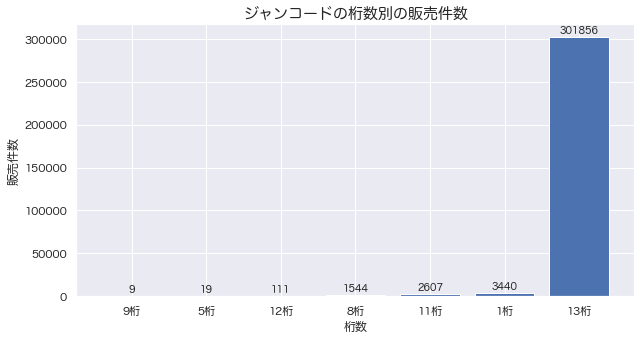

In [97]:
print('桁数別のカウント')
jancd_len_df_3121 = pd.DataFrame(jancd_list_3121, columns=['ジャンコード'])
jancd_len_df_3121['桁数'] = jancd_len_list_3121
jancd_len_count_3121 = jancd_len_df_3121['桁数'].value_counts()
X = jancd_len_count_3121.index.sort_values().astype(str)
Y = jancd_len_count_3121.sort_values().values

print('桁数別にプロット')
plt.figure(figsize=(10,5))
plt.title('ジャンコードの桁数別の販売件数', fontsize=15)
plt.xlabel('桁数')
plt.ylabel('販売件数')
records=jancd_len_count_3121.sort_values()
labels=['9桁','5桁','12桁','8桁','11桁','1桁','13桁']
color=['b']
va='bottom'
show_bar_count(labels, records, color, va);

桁数別のカウント
桁数別にプロット


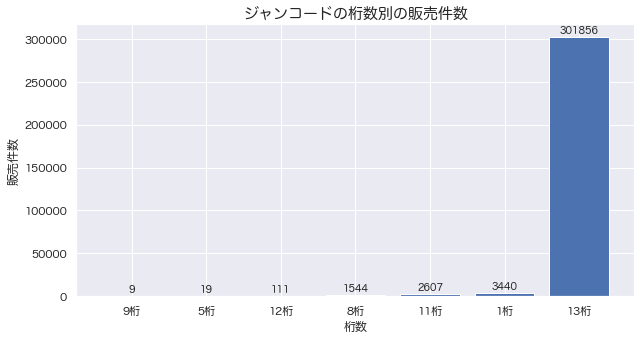

In [98]:
print('桁数別のカウント')
jancd_len_df_3122 = pd.DataFrame(jancd_list_3122, columns=['ジャンコード'])
jancd_len_df_3122['桁数'] = jancd_len_list_3122
jancd_len_count_3122 = jancd_len_df_3122['桁数'].value_counts()
X = jancd_len_count_3122.index.sort_values().astype(str)
Y = jancd_len_count_3122.sort_values().values

print('桁数別にプロット')
plt.figure(figsize=(10,5))
plt.title('ジャンコードの桁数別の販売件数', fontsize=15)
plt.xlabel('桁数')
plt.ylabel('販売件数')
records=jancd_len_count_3122.sort_values()
labels=['9桁','5桁','12桁','8桁','11桁','1桁','13桁']
color=['b']
va='bottom'
show_bar_count(labels, records, color, va);

In [99]:
print('ジャンコード取得_1')
len_jancd9 = jancd_len_df_3121[jancd_len_df_3121['桁数']==9].iloc[:1]
len_jancd5 =jancd_len_df_3121[jancd_len_df_3121['桁数']==5].iloc[:1]
len_jancd12 =jancd_len_df_3121[jancd_len_df_3121['桁数']==12].iloc[:1]
len_jancd8 =jancd_len_df_3121[jancd_len_df_3121['桁数']==8].iloc[:1]
len_jancd11 = jancd_len_df_3121[jancd_len_df_3121['桁数']==11].iloc[:1]
len_jancd1 = jancd_len_df_3121[jancd_len_df_3121['桁数']==1].iloc[:1]
len_jancd13 = jancd_len_df_3121[jancd_len_df_3121['桁数']==13].iloc[:1]

print('DataFrame_1 Union')
len_jancd95=len_jancd9.append(len_jancd5, ignore_index=True)
len_jancd9512=len_jancd95.append(len_jancd12, ignore_index=True)
len_jancd95128=len_jancd9512.append(len_jancd8, ignore_index=True)
len_jancd9512811=len_jancd95128.append(len_jancd11, ignore_index=True)
len_jancd95128111=len_jancd9512811.append(len_jancd1, ignore_index=True)
len_jancd9512811113=len_jancd95128111.append(len_jancd13, ignore_index=True)

print('ジャンコード取得_2')
len_jancd9_2 = jancd_len_df_3122[jancd_len_df_3122['桁数']==9].iloc[:1]
len_jancd5_2 =jancd_len_df_3122[jancd_len_df_3122['桁数']==5].iloc[:1]
len_jancd12_2 =jancd_len_df_3122[jancd_len_df_3122['桁数']==12].iloc[:1]
len_jancd8_2 =jancd_len_df_3122[jancd_len_df_3122['桁数']==8].iloc[:1]
len_jancd11_2 = jancd_len_df_3122[jancd_len_df_3122['桁数']==11].iloc[:1]
len_jancd1_2 = jancd_len_df_3122[jancd_len_df_3122['桁数']==1].iloc[:1]
len_jancd13_2 = jancd_len_df_3122[jancd_len_df_3122['桁数']==13].iloc[:1]

print('DataFrame_2 Union')
len_jancd95_2=len_jancd9_2.append(len_jancd5_2, ignore_index=True)
len_jancd9512_2=len_jancd95_2.append(len_jancd12_2, ignore_index=True)
len_jancd95128_2=len_jancd9512_2.append(len_jancd8_2, ignore_index=True)
len_jancd9512811_2=len_jancd95128_2.append(len_jancd11_2, ignore_index=True)
len_jancd95128111_2=len_jancd9512811_2.append(len_jancd1_2, ignore_index=True)
len_jancd9512811113_2=len_jancd95128111_2.append(len_jancd13_2, ignore_index=True)

jancd = pd.merge(len_jancd9512811113, len_jancd9512811113_2, on='桁数', how='left')
jancd = jancd.rename(columns={'ジャンコード_x': 'ジャンコード_3121'})
jancd = jancd.rename(columns={'ジャンコード_y': 'ジャンコード_3122'})
jancd

ジャンコード取得_1
DataFrame_1 Union
ジャンコード取得_2
DataFrame_2 Union


,ジャンコード_3121,桁数,ジャンコード_3122
0,990021054,9,990021054
1,49177,5,49177
2,760750666764,12,760750666764
3,49747140,8,49747140
4,55650000016,11,55650000016
5,0,1,0
6,4974305211712,13,4974305211712


### 考察

使用されているジャンコードの大半は13桁（98%）  
1桁は未登録、5桁はアイテムコードではないか。  

## 部門コード

### 集計

部門コード数_1： 25


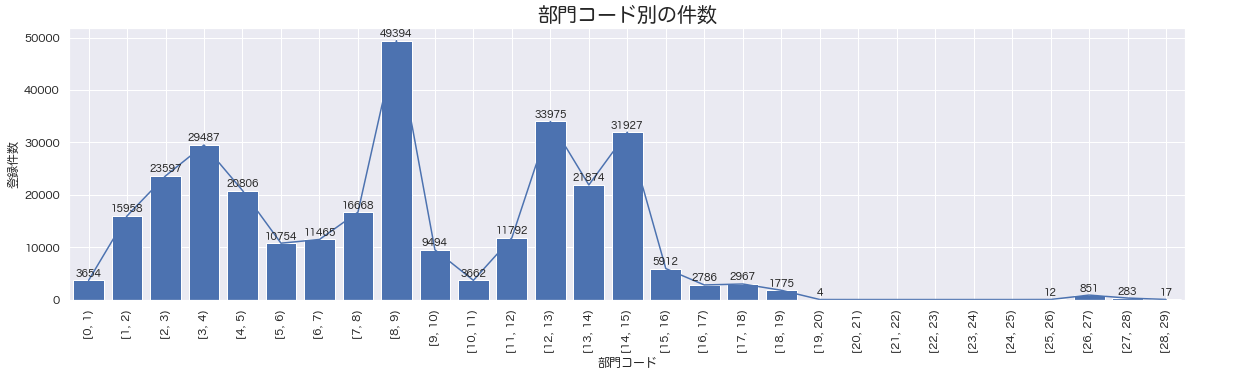

In [100]:
department_1 = sales_3121['部門コード'].value_counts(sort=True)
show_plot(sales_3121, '部門コード', 30, 1);

labels=department_1.index
records=department_1.values
color=['b']
va='bottom'
plt.grid()
plt.title('部門コード別の件数', fontsize=20)
plt.xlabel('部門コード')
plt.ylabel('登録件数')
show_bar_count(labels, records, color, va)
print(f'部門コード数_1： {len(department_1.value_counts())}');

部門コード数_2： 25


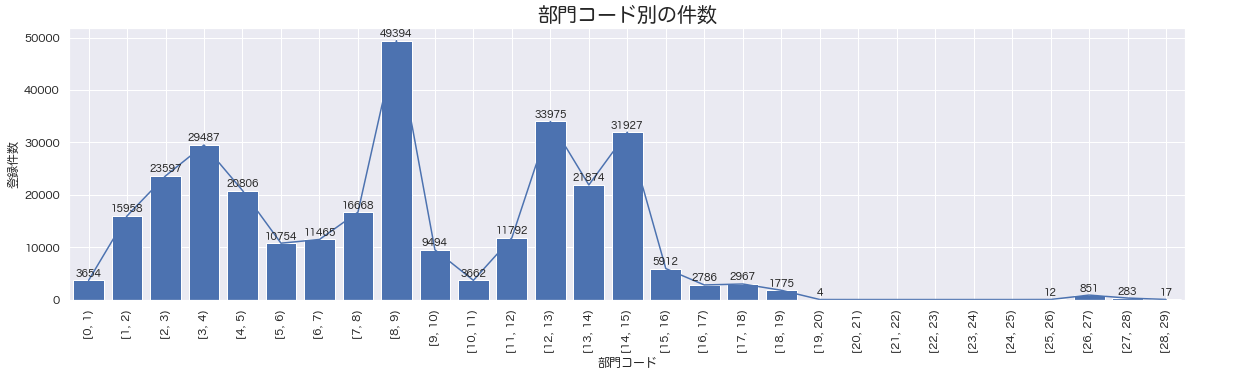

In [101]:
department_2 = sales_3122['部門コード'].value_counts(sort=True)
show_plot(sales_3122, '部門コード', 30, 1);

labels=department_2.index
records=department_2.values
color=['b']
va='bottom'
plt.grid()
plt.title('部門コード別の件数', fontsize=20)
plt.xlabel('部門コード')
plt.ylabel('登録件数')
show_bar_count(labels, records, color, va)
print(f'部門コード数_2： {len(department_2.value_counts())}');

/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='部門コード', ylabel='Density'>

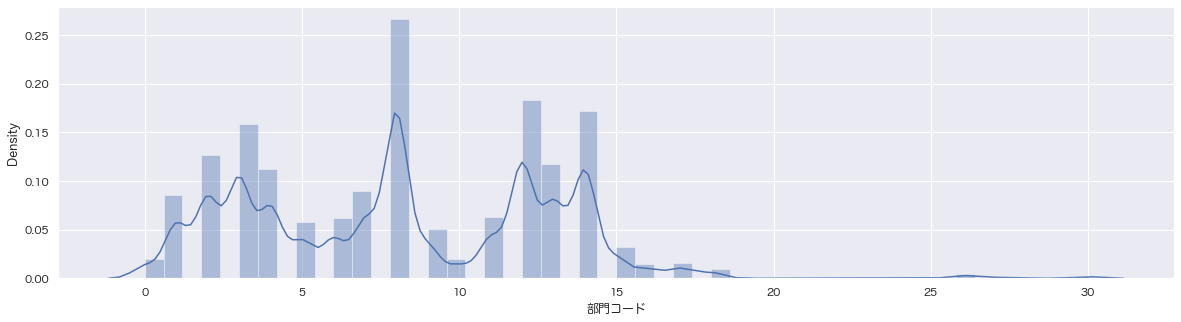

In [102]:
plt.grid()
sns.distplot(sales_3122['部門コード'])

### 考察

部門コード=4は、28456（7%）, 28806件（9%）。多少の差はあるが、同程度の正例比率。  
[sales_3121]と[sales_3122]でほぼ同等数。  
商品マスタの「部門」もほぼ同様。  

## 数量

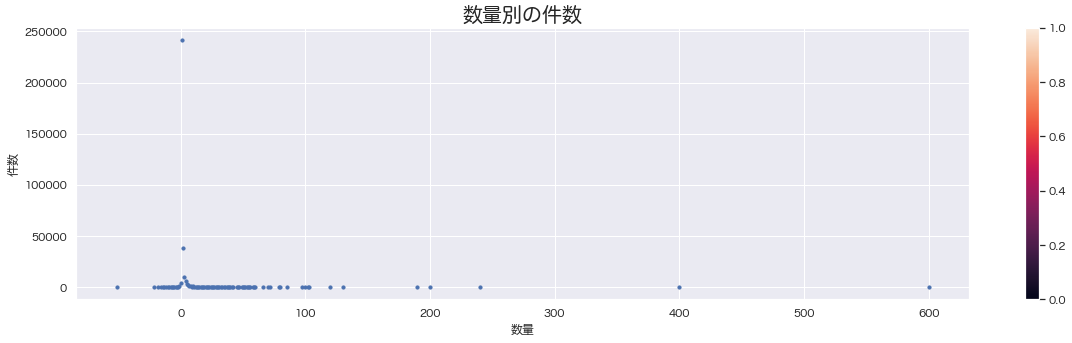

In [103]:
count_1 = sales_3121['数量'].value_counts()
x1 = count_1.index
y1 = count_1.values

plt.grid()
plt.title('数量別の件数', fontsize=20)
plt.xlabel('数量')
plt.ylabel('件数')
plt.scatter(x1, y1, s=10, cmap='Blues')
plt.colorbar();

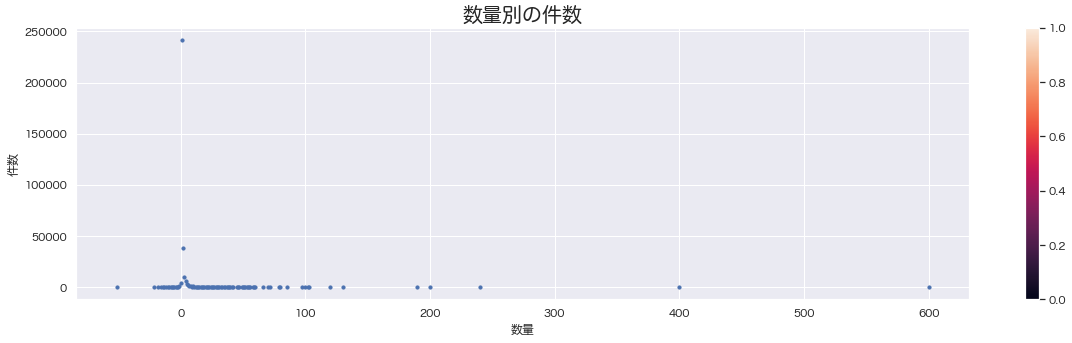

In [104]:
count_2 = sales_3122['数量'].value_counts()
x2 = count_2.index
y2 = count_2.values

plt.grid()
plt.title('数量別の件数', fontsize=20)
plt.xlabel('数量')
plt.ylabel('件数')
plt.scatter(x2, y2, s=10, cmap='Blues')
plt.colorbar();

In [105]:
print('数値=0のデータ確認')
sales_3121[sales_3121['数量']==0].head(2)
sales_3122[sales_3122['数量']==0].head(2);

数値=0のデータ確認


### 考察

単品購入が多数。  
数量=0が存在する。購入取り消し時の記録と思われる。ジャンコードが入力されていても、学習データからは弾くようにする。  
マイナスは返品数。  
200000件以上は、数量=1の単品購入者数。　　

## 売単価

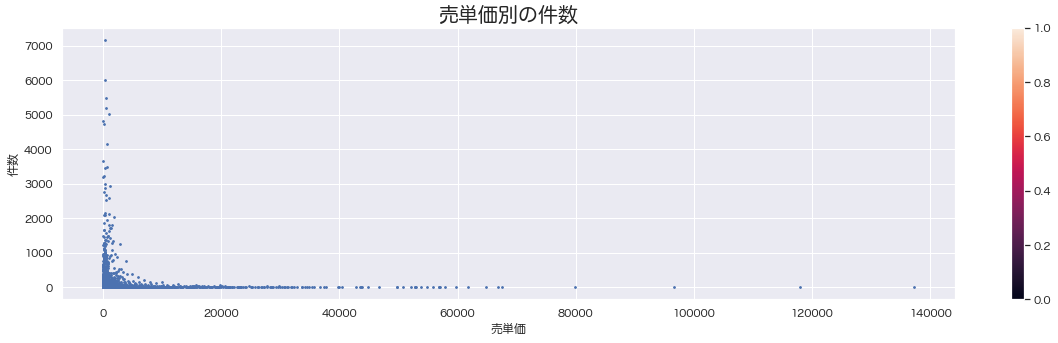

In [106]:
count_sale = sales_3121['売単価'].value_counts()
x_sale_1 = count_sale.index
y_sale_1 = count_sale.values

plt.grid()
plt.title('売単価別の件数', fontsize=20)
plt.xlabel('売単価')
plt.ylabel('件数')
plt.scatter(x_sale_1, y_sale_1, s=3, cmap='Blues')
plt.colorbar();

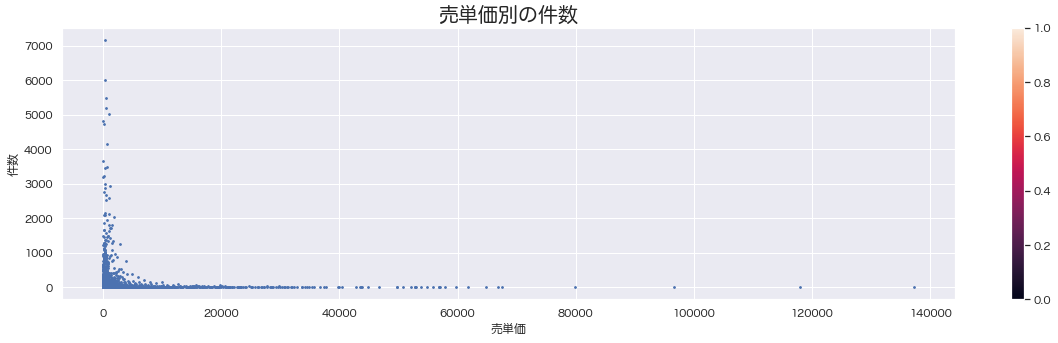

In [107]:
count_sale_2 = sales_3122['売単価'].value_counts()
x_sale_2 = count_sale_2.index
y_sale_2 = count_sale_2.values

plt.grid()
plt.title('売単価別の件数', fontsize=20)
plt.xlabel('売単価')
plt.ylabel('件数')
plt.scatter(x_sale_2, y_sale_2, s=3, cmap='Blues')
plt.colorbar();

## 原単価

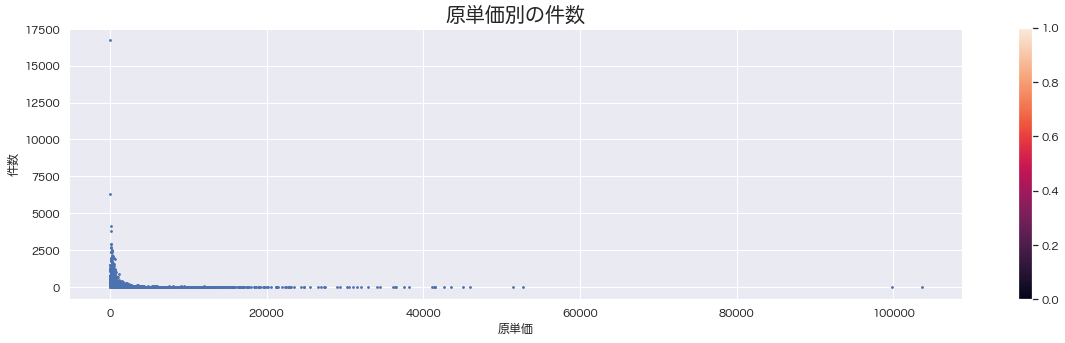

In [108]:
count_base_1 = sales_3121['原単価'].value_counts()
x_base_1 = count_base_1.index
y_base_1 = count_base_1.values

plt.grid()
plt.title('原単価別の件数', fontsize=20)
plt.xlabel('原単価')
plt.ylabel('件数')
plt.scatter(x_base_1, y_base_1, s=3, cmap='Blues')
plt.colorbar();

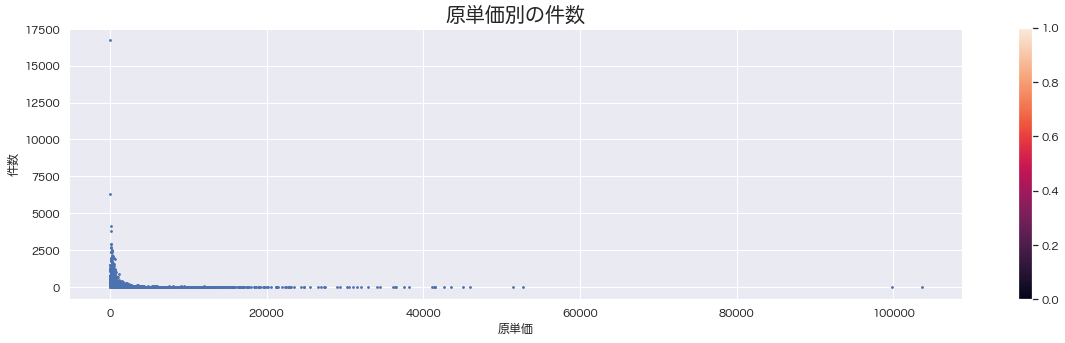

In [109]:
count_base_2 = sales_3122['原単価'].value_counts()
x_base_2 = count_base_2.index
y_base_2 = count_base_2.values

plt.grid()
plt.title('原単価別の件数', fontsize=20)
plt.xlabel('原単価')
plt.ylabel('件数')
plt.scatter(x_base_2, y_base_2, s=3, cmap='Blues')
plt.colorbar();

### 考察

5000円以下の商品数が多い。  
sales_3121の方が高額商品が売れている。  
sales_3121、sales_3122どちらも、売れている商品のほとんどは、¥60000以下である。  

## 値引

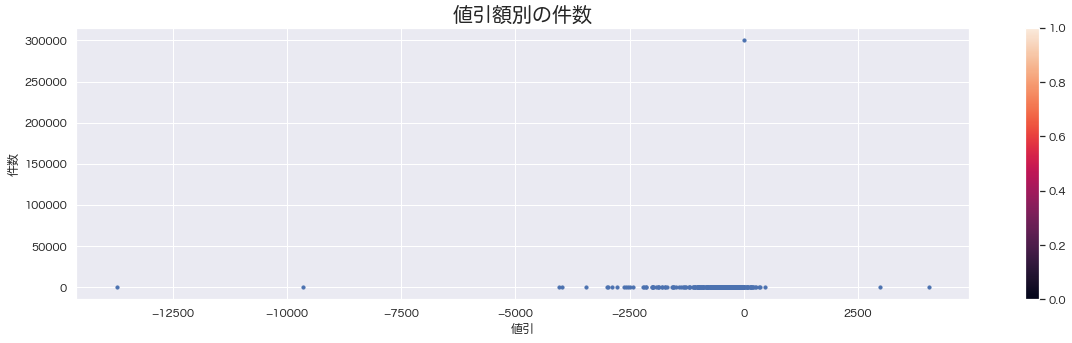

In [110]:
count_minus = sales_3121['値引'].value_counts()
x_minuse_1 = count_minus.index
y_minus_1 = count_minus.values

plt.grid()
plt.title('値引額別の件数', fontsize=20)
plt.xlabel('値引')
plt.ylabel('件数')
plt.scatter(x_minuse_1, y_minus_1, s=10, cmap='Blues')
plt.colorbar();

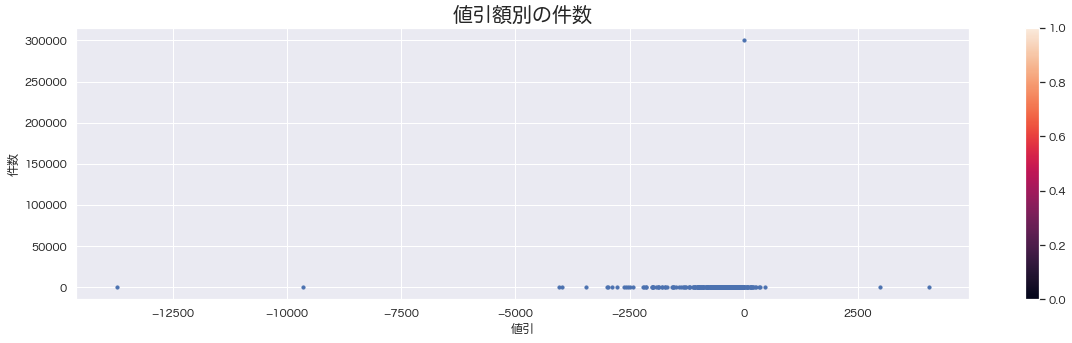

In [111]:
count_minus_2 = sales_3122['値引'].value_counts()
x_minuse_2 = count_minus_2.index
y_minus_2 = count_minus_2.values

plt.grid()
plt.title('値引額別の件数', fontsize=20)
plt.xlabel('値引')
plt.ylabel('件数')
plt.scatter(x_minuse_2, y_minus_2, s=10, cmap='Blues')
plt.colorbar();

### 考察

ほとんど（99%）の商品は値引きなし（値引=0）

## 販売金額

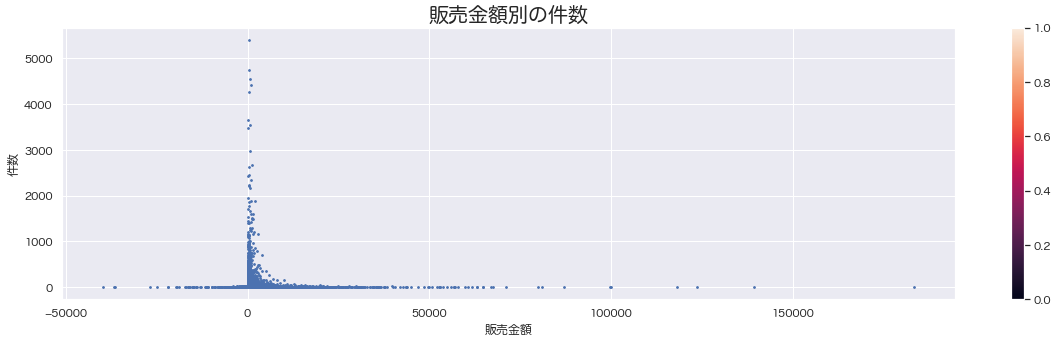

In [112]:
count_amount_1 = sales_3121['販売金額'].value_counts()
x_amount_1 = count_amount_1.index
y_amount_1 = count_amount_1.values

plt.grid()
plt.title('販売金額別の件数', fontsize=20)
plt.xlabel('販売金額')
plt.ylabel('件数')
plt.scatter(x_amount_1, y_amount_1, s=3, cmap='Blues')
plt.colorbar();

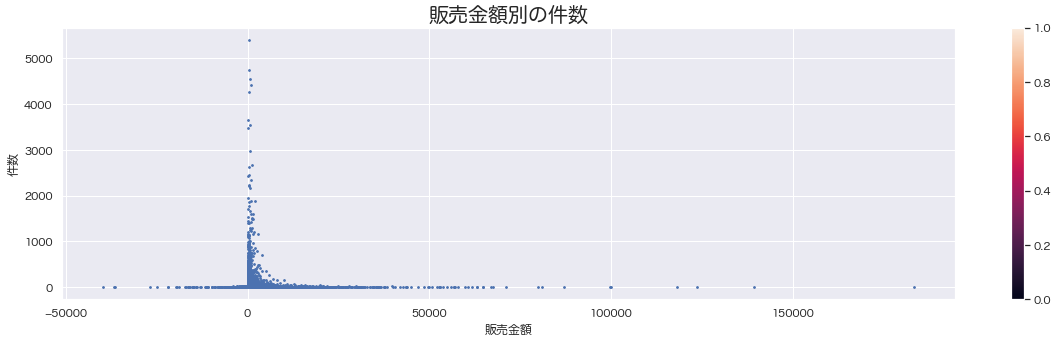

In [113]:
count_amount_2 = sales_3122['販売金額'].value_counts()
x_amount_2 = count_amount_2.index
y_amount_2 = count_amount_2.values

plt.grid()
plt.title('販売金額別の件数', fontsize=20)
plt.xlabel('販売金額')
plt.ylabel('件数')
plt.scatter(x_amount_2, y_amount_2, s=3, cmap='Blues')
plt.colorbar();

### 考察

5000円以下の商品が、1500回以下の販売回数が大半。  
マイナス値は返品分の金額と件数。  

## 顧客コード

In [114]:
print('重複あり')
value_len_df = pd.DataFrame(col_list_sale, columns=['値'])
value_len_df['長さ'] = value_len_list_sale
value_len_count = value_len_df['長さ'].value_counts()

value_len_sale_df = pd.DataFrame()
value_len_sale_df['顧客コードの桁数'] = value_len_count.index
value_len_sale_df['来店数'] = value_len_count.values
value_len_sale_df

重複あり


,顧客コードの桁数,来店数
0,11,294219
1,13,12371
2,10,2994
3,4,1
4,1,1


### 考察

97%は11桁の顧客コード

# 時系列データ分析

## データ準備

In [115]:
print('結合')
customers_sales = pd.merge(customers, sales_3121, on='顧客コード', how='left')
print('外部結合用にリネーム')
items_rename = items.rename(columns={'JANCD': 'ジャンコード'})
print('結合')
customers_sales_items = pd.merge(customers_sales, items_rename, on='ジャンコード', how='left')

print('返品情報を除外')
over = customers_sales_items[customers_sales_items['数量']>=0]

print('売上履歴、商品マスタの紐づかないレコードは対象外')
positive = over[over['大分類'].notnull()]
hyphen = positive.copy()

print('郵便番号の「ハイフン（-）」を置換')
hyphen['郵便番号'] = positive['郵便番号'].str.replace('-','')
join = hyphen.copy()

print('日本郵政の郵便番号・住所情報を取得')
zipno=[]
zip_rome=[]
shi=[]
with open('KEN_ALL_ROME.csv', 'rt', encoding='Shift_JIS') as fp:
    reader = csv.reader(fp)
    for row in reader:
        zipno.append(row[0])
        zip_rome.append(row[1])
        shi.append(row[2])

zip_df = pd.DataFrame()
zip_df['郵便番号'] = zipno
zip_df['都道府県'] = zip_rome
zip_df['市区町村'] = shi
zip_df.sort_values(by='郵便番号').head(1)

print('住所結合')
df_zip = pd.DataFrame()
df_zip = pd.merge(join, zip_df, on='郵便番号', how='left')
df_zip[['顧客コード', '郵便番号', '都道府県', '市区町村']].tail(1)
print('都道府県、市区町村の欠損値を高知県・高知市（最頻値）で補完')
df_zip['都道府県'] = df_zip['都道府県'].fillna('高知県')
df_zip['市区町村'] = df_zip['市区町村'].fillna('高知市')

print('誕生日未登録を平均値で補完')
birthday = df_zip.copy()
condition = birthday['誕生日'].isnull()
birthday['誕生日'] = birthday['誕生日'].where(~condition , birthday['誕生日'].mean())
birthday[birthday['誕生日'].notnull()][['顧客コード', '誕生日']].head(1)

print('誕生日==0(未入力), 2040（誤り）のデータを置換')
age = birthday.copy()
condition1 = (age['誕生日'] < 1)
condition2 = (age['誕生日'] > 2020)
age['誕生日'] = age['誕生日'].where(~condition1, age['誕生日'].median())
age['誕生日'] = age['誕生日'].where(~condition2, age['誕生日'].median())

print('年齢を設定')
year = 2020
age['年齢'] = year - age['誕生日']
age.head(1)

print("時間項目を4桁の固定長に変換")
time_series = age.copy()
time_series['日付'] = time_series['日付'].astype(int).astype(str)
time_series['時間'] = time_series['時間'].astype(int).astype(str)
list = []
for index in tqdm(time_series.index):
    if (len(time_series['時間'][index])<4):
        list.append(time_series['時間'][index].zfill(4))
    else:
        list.append(time_series['時間'][index])
time_series['時間'] = list

print("日付時間をインデックスに設定")
time_series["日付時間"] = pd.to_datetime( (time_series['日付'].astype(str)).str.cat([(time_series['時間'].astype(str))], sep=' ') )
time_series = time_series.set_index('日付時間').sort_index(ascending=True)
time_series.head(2);

結合
外部結合用にリネーム
結合
返品情報を除外
売上履歴、商品マスタの紐づかないレコードは対象外
郵便番号の「ハイフン（-）」を置換
日本郵政の郵便番号・住所情報を取得
住所結合
都道府県、市区町村の欠損値を高知県・高知市（最頻値）で補完
誕生日未登録を平均値で補完
誕生日==0(未入力), 2040（誤り）のデータを置換
年齢を設定
時間項目を4桁の固定長に変換


100%|██████████| 304323/304323 [00:04<00:00, 65884.26it/s]


日付時間をインデックスに設定


## ADF検定（定常性の確認）

帰無仮説：単位根課程  
対立仮設：定常過程  
P値が0.05以下の場合、帰無仮説が棄却し、定常過程を正とする。  

In [116]:
from statsmodels.tsa import stattools

print('')
adf_df = pd.DataFrame(
    [
        stattools.adfuller(time_series.resample('M')['レシートNo'].sum())[1],
        stattools.adfuller(time_series.resample('M')['レシート行'].sum())[1],
        stattools.adfuller(time_series.resample('M')['数量'].sum())[1],
        stattools.adfuller(time_series.resample('M')['売単価'].sum())[1],
        stattools.adfuller(time_series.resample('M')['販売金額'].sum())[1]
    ],
    index=['レシートNo', 'レシート行', '数量', '売単価', '販売金額'],
    columns=['P値']
)
adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
adf_df

,P値
レシートNo,0.118
レシート行,0.244
数量,0.119
売単価,0.171
販売金額,0.0


### 考察（ADF検定）

レシート行は、周期的に採番されされるが、時系列データではないものと思われる。

## 周期生の分析

### 成分分解

In [117]:
print('表示サイズ調整')
plt.rcParams["figure.figsize"] = [20,8]
plt.rcParams["font.size"] = 10

表示サイズ調整


In [118]:
print('原系列、傾向（トレンド）、周期変動（季節性）、不規則変動（残差）')
import statsmodels.api as sm
def show_seasonal_decompose(df, col_name):
    sd_df = df[col_name]
    res = sm.tsa.seasonal_decompose(sd_df, period=51)
    fig = res.plot()
    plt.show();

原系列、傾向（トレンド）、周期変動（季節性）、不規則変動（残差）


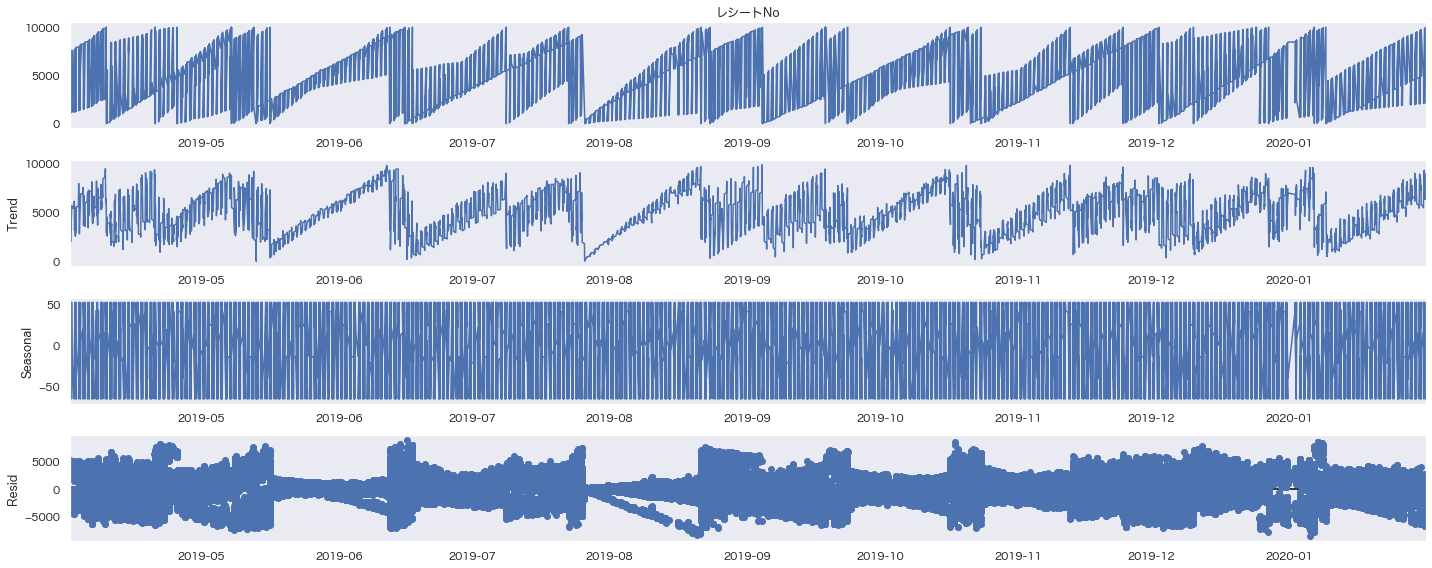

In [119]:
show_seasonal_decompose(time_series, 'レシートNo');

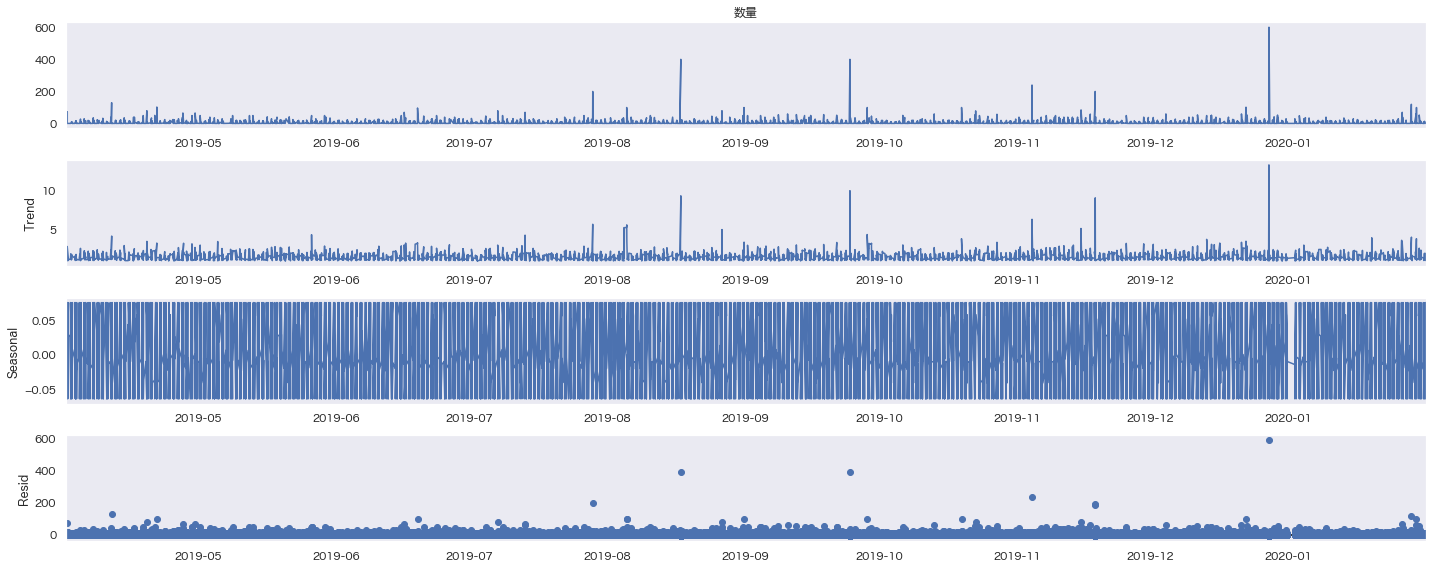

In [120]:
show_seasonal_decompose(time_series, '数量');

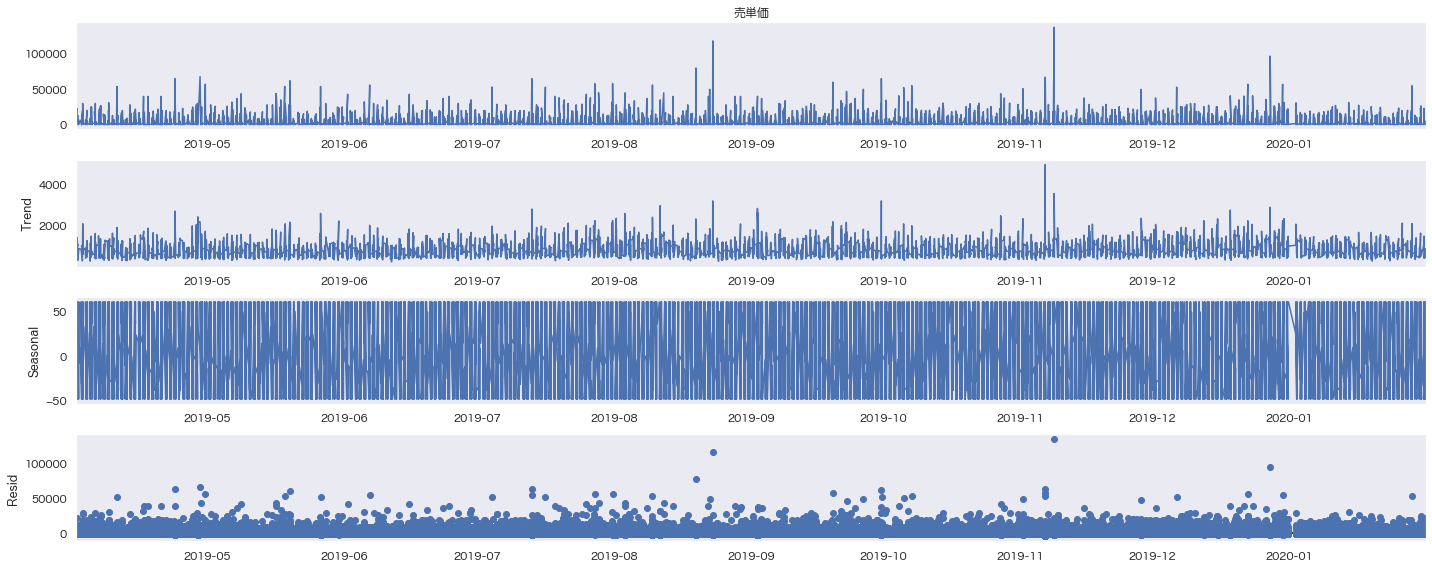

In [121]:
show_seasonal_decompose(time_series, '売単価');

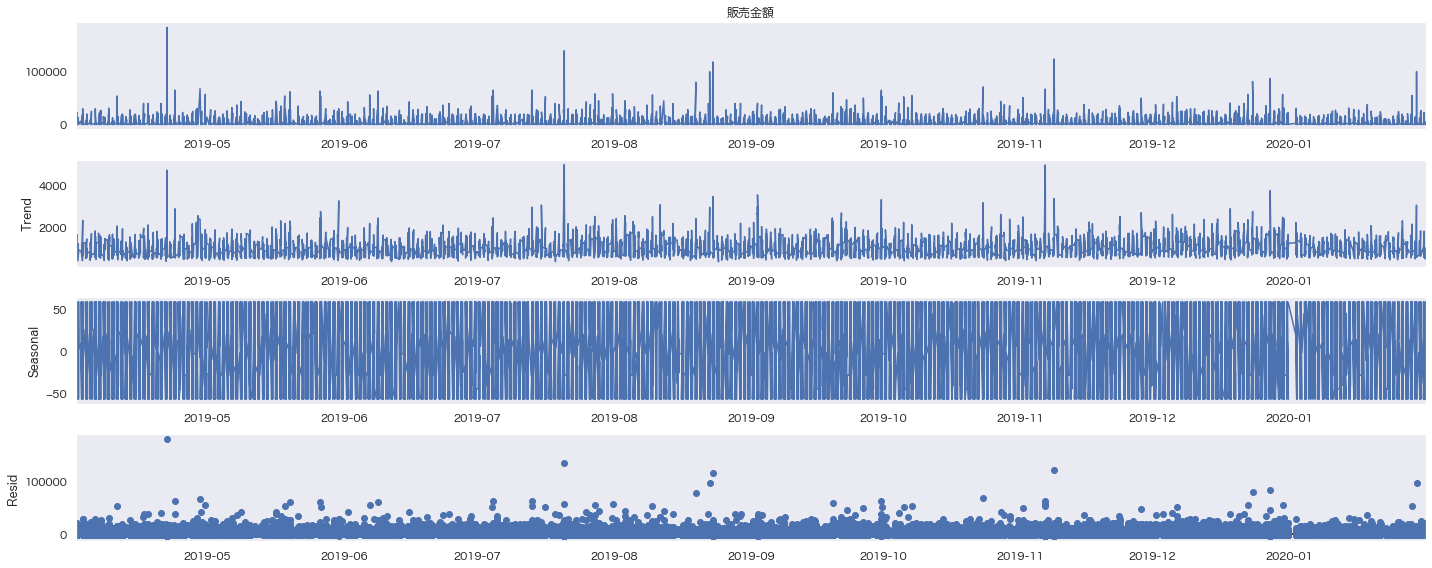

In [122]:
show_seasonal_decompose(time_series, '販売金額');

### 考察

5,8,10,1月の売上数の上昇が見られる。  
ただし季節性はなさそう。  

### コレログラム

In [123]:
print('表示サイズ調整')
plt.rcParams["figure.figsize"] = [20,2]
plt.rcParams["font.size"] = 5

表示サイズ調整


日別300日分のコレログラム


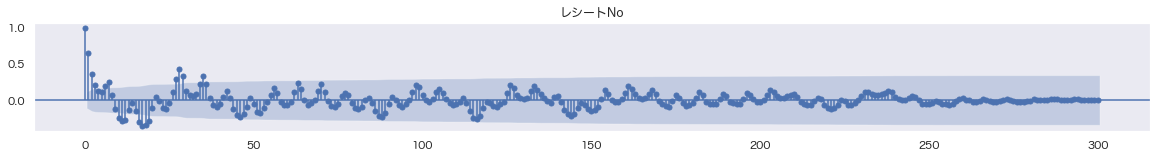

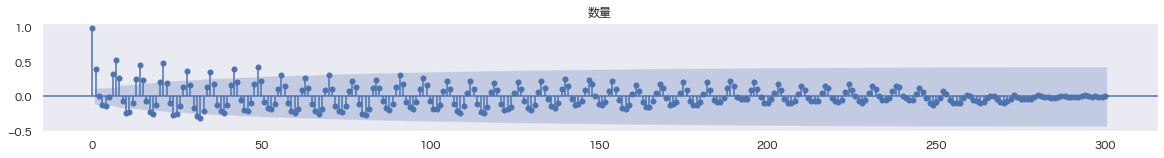

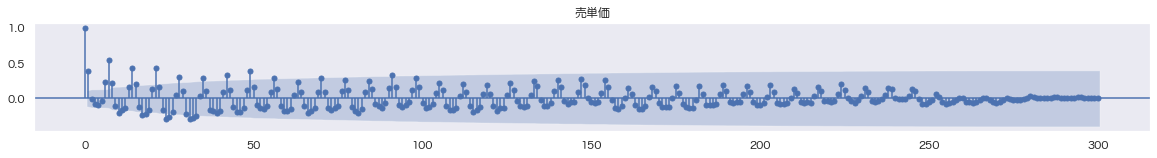

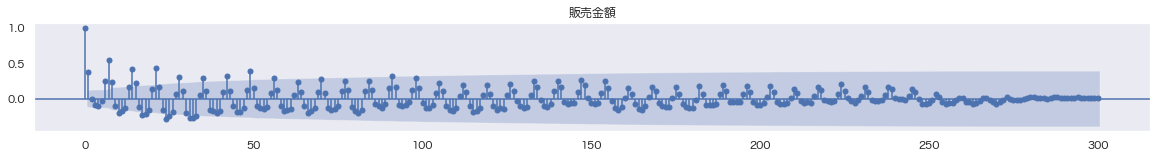

In [124]:
print('日別300日分のコレログラム')
sm.graphics.tsa.plot_acf( time_series.resample('D')['レシートNo'].sum(), title='レシートNo', lags=300)
sm.graphics.tsa.plot_acf( time_series.resample('D')['数量'].sum(), title='数量', lags=300)
sm.graphics.tsa.plot_acf( time_series.resample('D')['売単価'].sum(), title='売単価', lags=300)
sm.graphics.tsa.plot_acf( time_series.resample('D')['販売金額'].sum(), title='販売金額', lags=300);

週別40週分のコレログラム


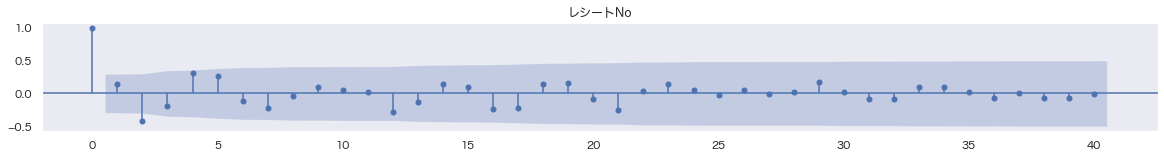

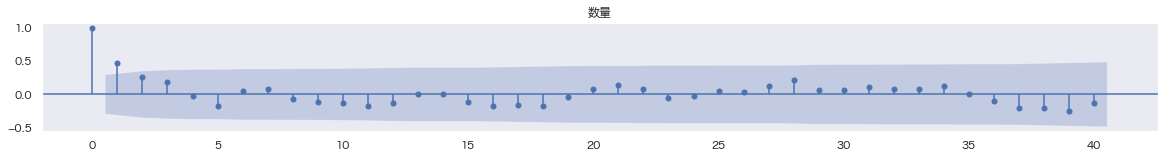

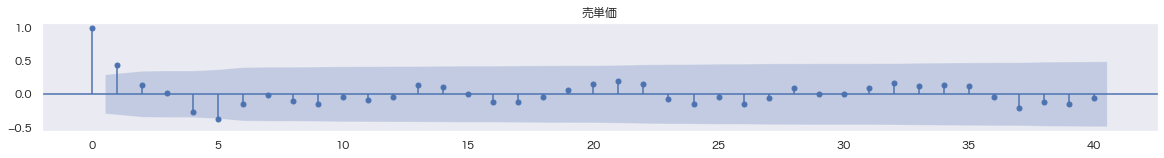

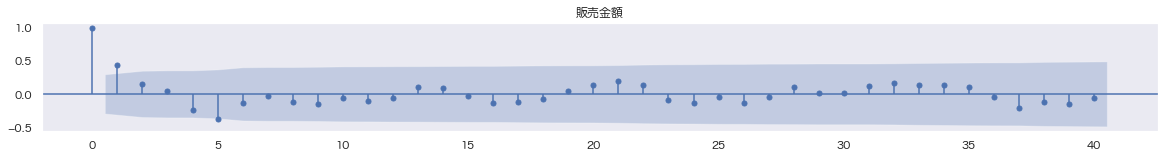

In [125]:
print('週別40週分のコレログラム')
sm.graphics.tsa.plot_acf( time_series.resample('W')['レシートNo'].sum(), title='レシートNo', lags=40)
sm.graphics.tsa.plot_acf( time_series.resample('W')['数量'].sum(), title='数量', lags=40)
sm.graphics.tsa.plot_acf( time_series.resample('W')['売単価'].sum(), title='売単価', lags=40)
sm.graphics.tsa.plot_acf( time_series.resample('W')['販売金額'].sum(), title='販売金額', lags=40);

月別10ヶ月分のコレログラム


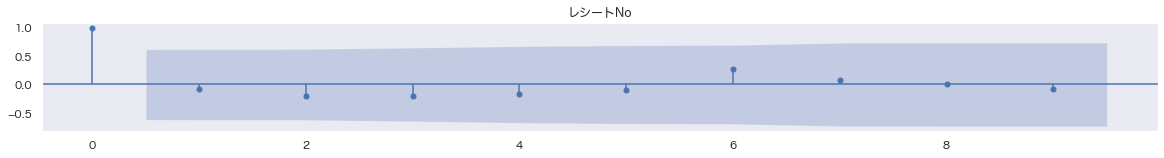

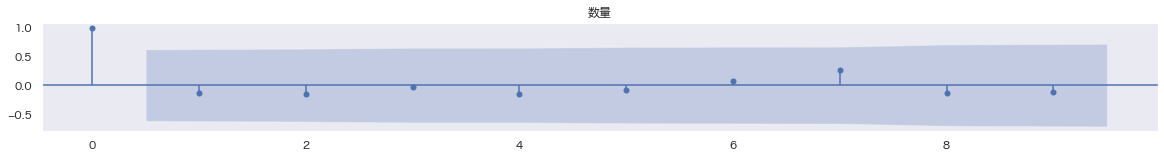

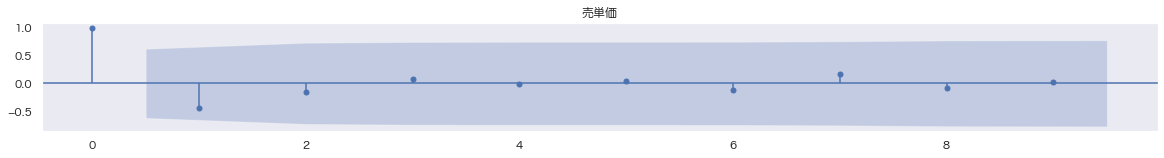

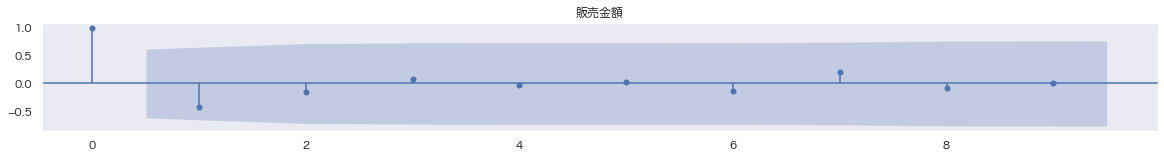

In [126]:
print('月別10ヶ月分のコレログラム')
sm.graphics.tsa.plot_acf( time_series.resample('M')['レシートNo'].sum(), title='レシートNo', lags=9)
sm.graphics.tsa.plot_acf( time_series.resample('M')['数量'].sum(), title='数量', lags=9)
sm.graphics.tsa.plot_acf( time_series.resample('M')['売単価'].sum(), title='売単価', lags=9)
sm.graphics.tsa.plot_acf( time_series.resample('M')['販売金額'].sum(), title='販売金額', lags=9);

最も対象商品の売上数の多い12月に絞って分析する
日別30日分のコレログラム


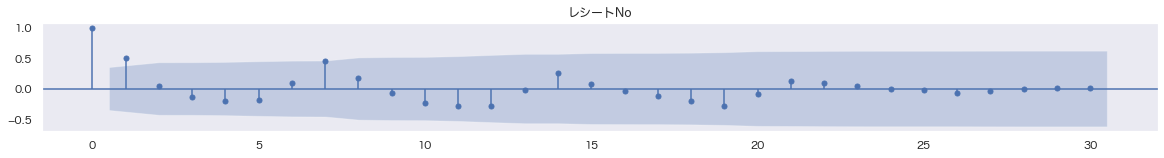

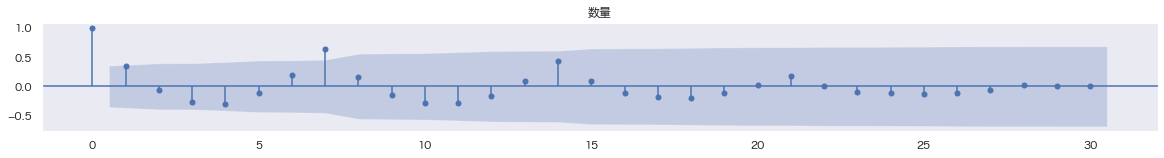

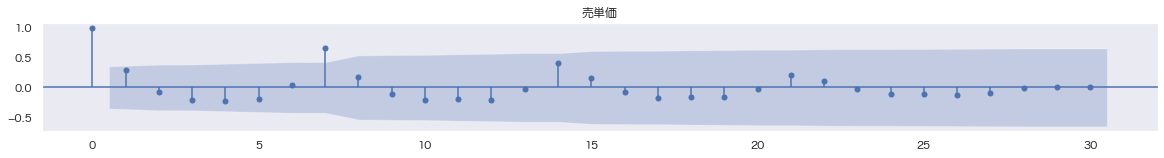

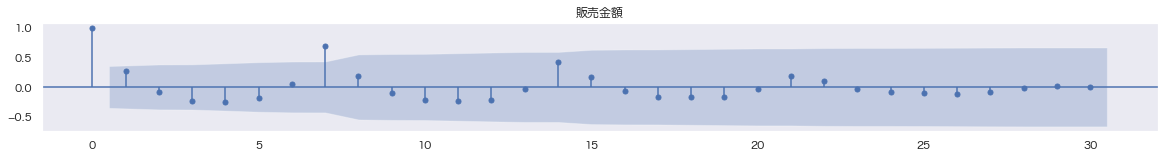

In [127]:
print('最も対象商品の売上数の多い12月に絞って分析する')
print('日別30日分のコレログラム')
time_series_5m = time_series[ (time_series['日付'].astype(int)>=20191201) & (time_series['日付'].astype(int)<=20191231) ].copy()

sm.graphics.tsa.plot_acf( time_series_5m.resample('D')['レシートNo'].sum(), title='レシートNo', lags=30)
sm.graphics.tsa.plot_acf( time_series_5m.resample('D')['数量'].sum(), title='数量', lags=30)
sm.graphics.tsa.plot_acf( time_series_5m.resample('D')['売単価'].sum(), title='売単価', lags=30)
sm.graphics.tsa.plot_acf( time_series_5m.resample('D')['販売金額'].sum(), title='販売金額', lags=30);

### 考察

料金、数量は、１週間単位の周期、土日の売上数の向上が見られる。  
月別ではあまり大きな周期性は見られない。ゆるやかな変動は見られる。  
特徴量に曜日をOne Hot エンコーディングで設け、土日を表現する。  

In [128]:
print('表示サイズ再調整')
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["font.size"] = 10

表示サイズ再調整


# 相関分析

## 目的変数（購入フラグ）の生成

In [129]:
print('売上履歴、商品マスタの紐づかないレコードは対象外とする')
correlation = time_series.copy()
corr= pd.DataFrame()
corr = correlation[correlation['大分類'].notnull()]

print('更新条件セット')
cond1 = corr['部門コード']==4
cond2 = corr['大分類']==11
cond3 = corr['中分類']==1
cond4 = corr['中分類']==2
cond1234 = (cond1) & (cond2) & ((cond3 | cond4))

print('購入フラグの設定')
corr['購入フラグ']=1
corr['購入フラグ'] = corr['購入フラグ'].where((cond1234), 0);

売上履歴、商品マスタの紐づかないレコードは対象外とする
更新条件セット
購入フラグの設定


In [130]:
print("正例・負例件数")
corr['購入フラグ'].value_counts();

正例・負例件数


月別の合計数をプロット





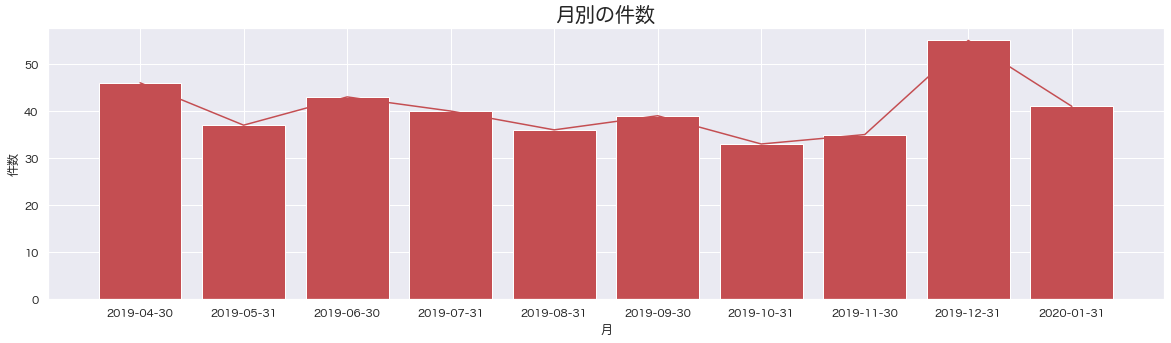

In [131]:
print("月別の合計数をプロット")
print('')
index = corr.copy()
index['日付'] = index['日付'].astype(int).astype(str)
index['時間'] = index['時間'].astype(str)
index["日付時間"] = pd.to_datetime( index['日付'].str.cat( [index['時間']], sep=' ') )
index = index.set_index('日付時間')
index = index.sort_index()

print('')
month_target = index.resample('M')['購入フラグ'].sum()
month_all = index.resample('M')['購入フラグ'].count()

print('')
x1 = month_target.index.astype(str)
y1 = month_target.values
plt.grid()
plt.title('月別の件数', fontsize=20)
plt.xlabel('月')
plt.ylabel('件数')
plt.plot(x1, y1, color='r')
plt.bar(x1, y1, color='r');

負例件数
プロット


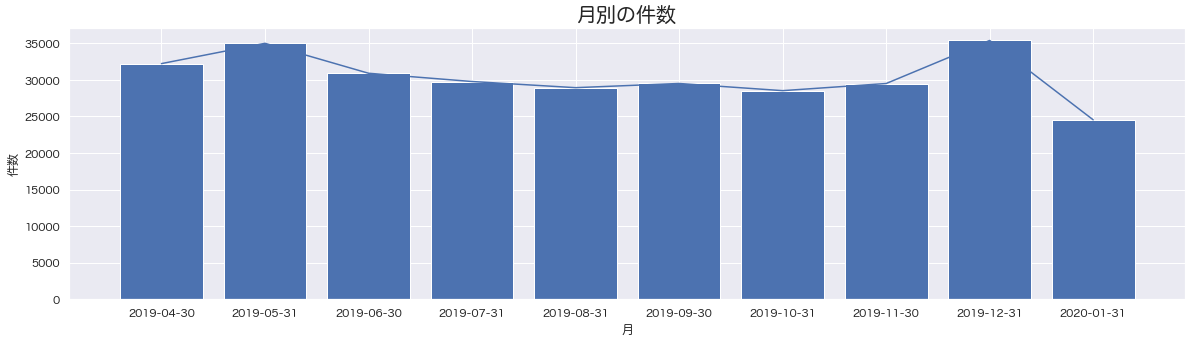

In [132]:
print('負例件数')
x2 = month_all.index.astype(str)
y2 = month_all.values
print('プロット')
plt.grid()
plt.title('月別の件数', fontsize=20)
plt.xlabel('月')
plt.ylabel('件数')
plt.bar(x2, y2, color='b')
plt.plot(x2, y2, color='b');

### 考察

正例平均：毎月65件、負例平均：毎月40000件。    
正例：負例=1:615  
不均衡データ  

## ペアプロット

In [133]:
# print('データ少量化')
# df_int = age.copy()
# df_int = df_int[ (df_int['日付']>=20190501) & (df_int['日付']<=20190531)]
# print('プロット')
# pair_columns = ['顧客コード', '性別', '郵便番号', '誕生日']
# df_int = df_int[pair_columns]
# df_int = df_int.astype(int)
# sns.pairplot(df_int, kind = "reg", vars = pair_columns);

## 相関行列

変数の設定
集計
描画


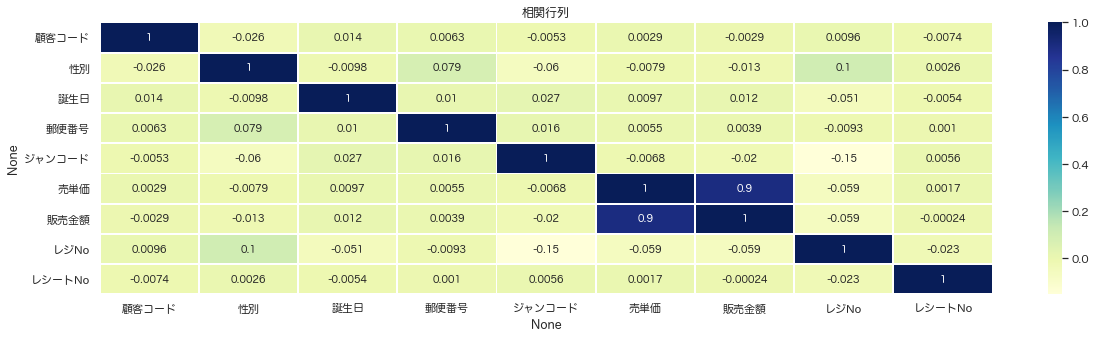

In [134]:
print('変数の設定')
corr1=corr['顧客コード']
corr2=corr['性別']
corr3=corr['誕生日']
corr4=corr['郵便番号']
corr5=corr['ジャンコード']
corr6=corr['売単価']
corr7=corr['販売金額']
corr8=corr['レジNo']
corr9=corr['レシートNo']

print('集計')
resid_mat = pd.DataFrame()
for ts in[corr1, corr2, corr3, corr4, corr5, corr6, corr7, corr8, corr9]:
    res = sm.tsa.seasonal_decompose(ts, period=90)
    resid_mat = pd.concat([resid_mat, pd.Series(res.resid)], axis=1)
resid_mat.columns =[['顧客コード', '性別', '誕生日', '郵便番号', 'ジャンコード', '売単価', '販売金額', 'レジNo', 'レシートNo']]

print('描画')
sns.heatmap(resid_mat.corr(), annot=True, lw=0.7, cmap='YlGnBu')
plt.title('相関行列');

### 考察

もともとあった変数では、相関が低い。新たに特徴量を生成する必要がある。  
単体では影響度が低そうな為、合成変数も作成する。  

## 2変数の相関分析

In [135]:
print('関数の定義')
def plot_target_stats(df, tgt_col, col, agg_dict, plot_config):
    print('col：Group byのkey')
    print('agg_dict：集計対象と集計方法')
    count_col = tgt_col + '_count'
    mean_col = tgt_col + '_mean'
    plt_data = grouping(df, col, agg_dict, prefix='')

    print('2軸グラフの作成')
    fig, ax1 = plt.subplots(figsize = (20 , 5))
    ax2 = ax1.twinx()

    ax1.bar(plt_data[col], plt_data[count_col], label=count_col, color='skyblue', **plot_config['bar'])
    ax2.plot(plt_data[col], plt_data[mean_col], label=mean_col, color='red', marker='.', markersize=10)

    h1, label1 = ax1.get_legend_handles_labels()
    h2, label2 = ax2.get_legend_handles_labels()

    ax1.legend(h1 + h2, label1 + label2, loc=2, borderaxespad=0.)
    ax1.set_xticks(plt_data[col])
    ax1.set_xticklabels(plt_data[col],rotation=-90, fontsize=2)

    ax1.set_title(f"Relationship between {col}, {count_col}, and {mean_col}", fontsize=14)
    ax1.set_xlabel(f"{col}")
    ax1.tick_params(labelsize=12)

    ax1.set_ylabel(count_col)
    ax2.set_ylabel(mean_col)

    ax1.set_ylim([0, plt_data[count_col].max() * 1.2])
    ax2.set_ylim([0, plt_data[mean_col].max() * 1.1]);

関数の定義


In [136]:
print('関数の定義')
def grouping(df, cols, agg_dict, prefix=''):
    group_df = df.groupby(cols).agg(agg_dict)
    group_df.columns = [prefix + c[0] + '_' + c[1] for c in group_df.columns.to_list()]
    group_df.reset_index(inplace = True)
    return group_df

関数の定義


### 購入フラグ×性別

プロット
col：Group byのkey
agg_dict：集計対象と集計方法
2軸グラフの作成


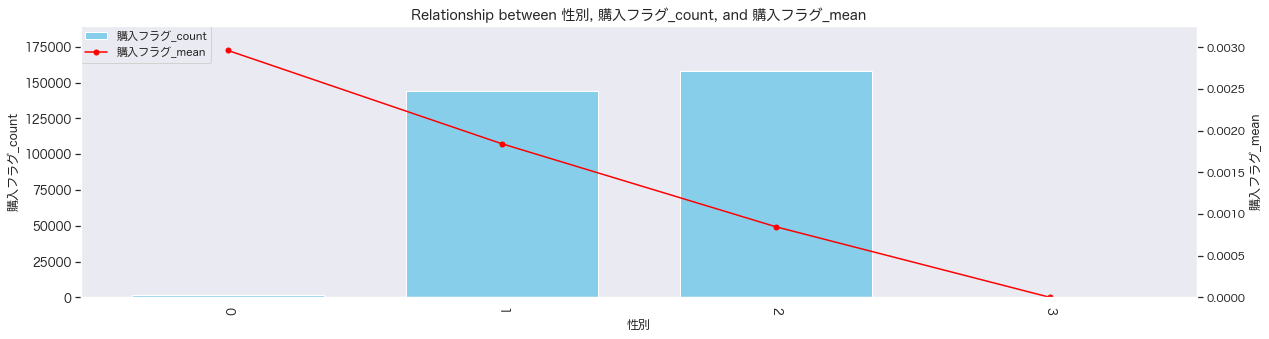

In [137]:
tgt_col = '購入フラグ'
col_name = '性別'

print('プロット')
agg_dict = {tgt_col : ['count', 'mean']}
plot_config = {'bar': {'width': 0.7}}
plot_target_stats(corr, tgt_col, col_name, agg_dict, plot_config);

### 購入フラグ×年齢

プロット
col：Group byのkey
agg_dict：集計対象と集計方法
2軸グラフの作成


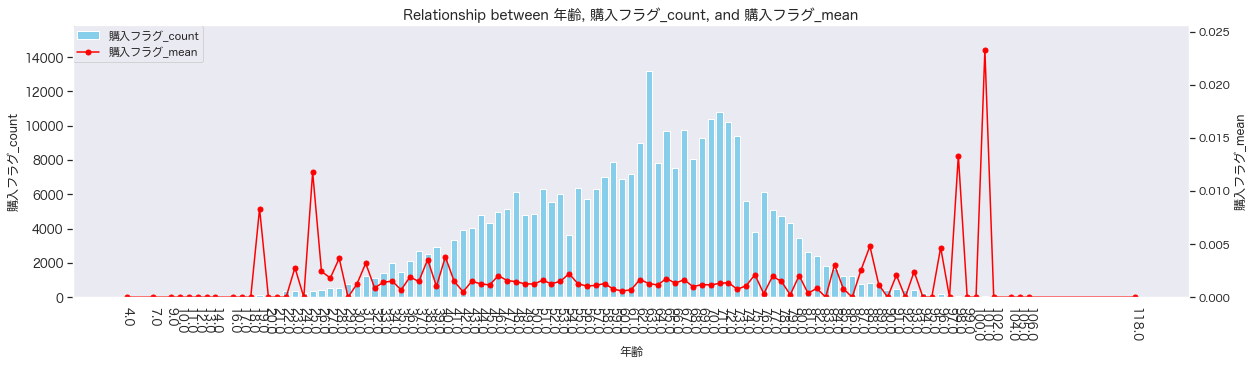

In [138]:
tgt_col = '購入フラグ'
col_name = '年齢'

print('プロット')
agg_dict = {tgt_col : ['count', 'mean']}
plot_config = {'bar': {'width': 0.7}}
plot_target_stats(corr, tgt_col, col_name, agg_dict, plot_config);

### 購入フラグ×市区町村

プロット
col：Group byのkey
agg_dict：集計対象と集計方法
2軸グラフの作成


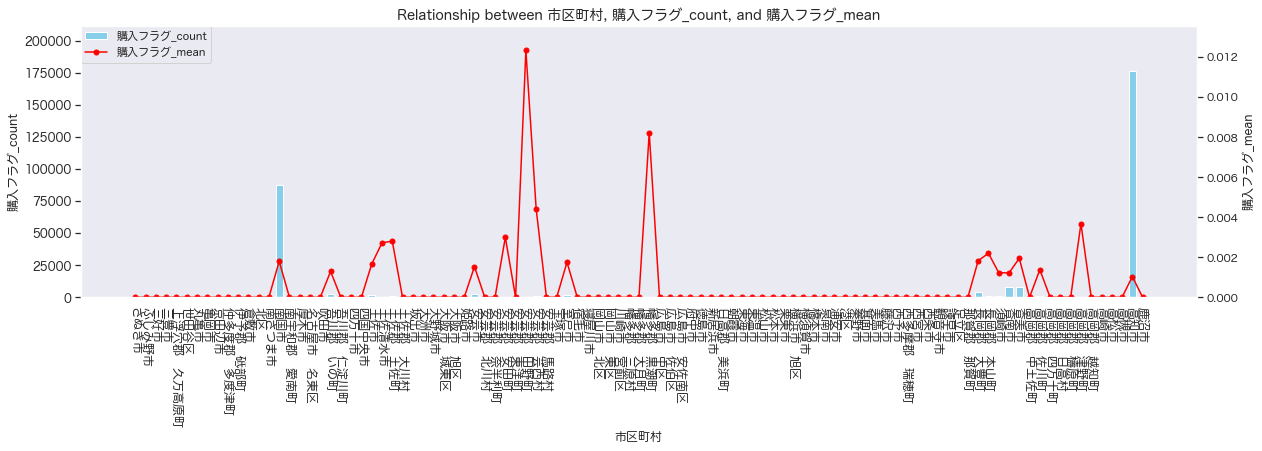

In [139]:
tgt_col = '購入フラグ'
col_name = '市区町村'

print('プロット')
agg_dict = {tgt_col : ['count', 'mean']}
plot_config = {'bar': {'width': 0.7}}
plot_target_stats(corr, tgt_col, col_name, agg_dict, plot_config);

### 購入フラグ×数量

プロット
col：Group byのkey
agg_dict：集計対象と集計方法
2軸グラフの作成


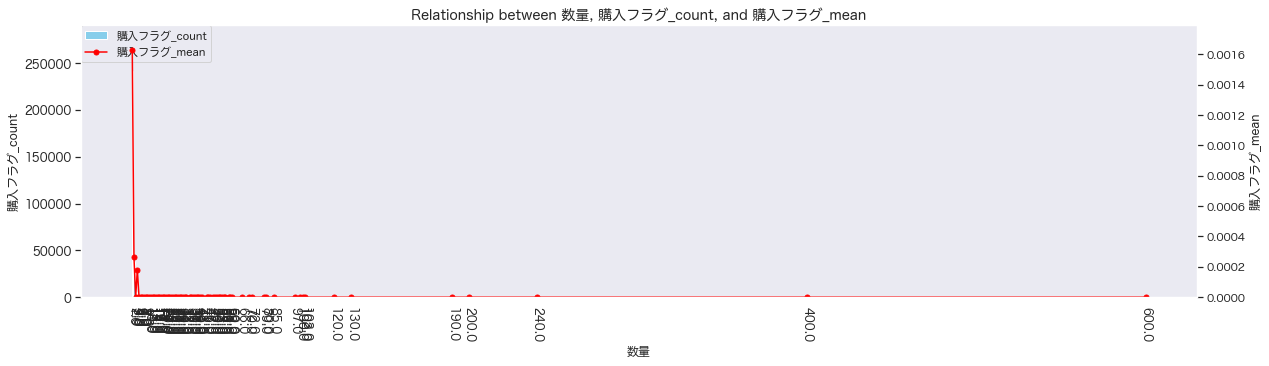

In [140]:
tgt_col = '購入フラグ'
col_name = '数量'

print('プロット')
agg_dict = {tgt_col : ['count', 'mean']}
plot_config = {'bar': {'width': 0.7}}
plot_target_stats(corr, tgt_col, col_name, agg_dict, plot_config);

### 購入フラグ×レジNo

プロット
col：Group byのkey
agg_dict：集計対象と集計方法
2軸グラフの作成


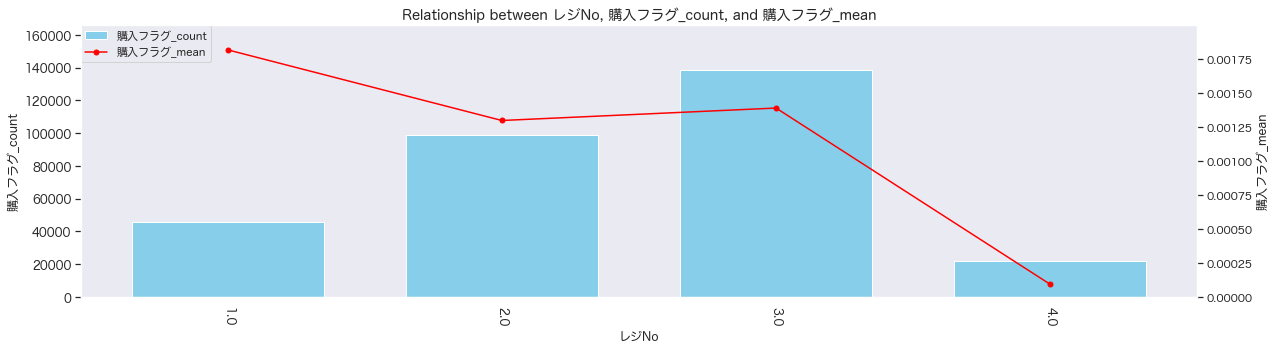

In [141]:
tgt_col = '購入フラグ'
col_name = 'レジNo'

print('プロット')
agg_dict = {tgt_col : ['count', 'mean']}
plot_config = {'bar': {'width': 0.7}}
plot_target_stats(corr, tgt_col, col_name, agg_dict, plot_config);

### 考察

性別：男女の絶対数はほぼ同じだが、正例比率は2の方が高い。  
年齢：絶対値は40〜70代が多いが、割合は各年代に差があまりない。  
市区町村：高知県、高知市周辺に対象商品の購買顧客が集中している。  
数量：5件以下が大半  
レジNo：No.2〜3番レジに対象商品の購買が集中している。  

# 検定

In [142]:
test = corr.copy()

## F検定（等分散性の検定）

In [143]:
from scipy import stats
from scipy.stats import f

In [144]:
print('F検定用の関数')
def ftest(a, b):
    print('統計量Fの計算')
    v1 = np.var(a, ddof=1)
    v2 = np.var(b, ddof=1)
    n1 = len(a)
    n2 = len(b)
    f_value = v1/v2

    print('帰無仮説が正しい場合にFが従う確率分を生成')
    f_frozen = f.freeze(dfn=n1-1, dfd=n2-1)

    p1 = f_frozen.sf(f_value)
    p2 = f_frozen.cdf(f_value)
    print('両側検定')
    print('小さい方の2倍をp値とする')
    p_value = min(p1, p2) * 2
    
    print('バイオリンプロット')
    plt.title('正例、負例の分布', fontsize=20)
    plt.xlabel('正例、負例')
    plt.ylabel('年齢')
    sns.violinplot(x=['A' for i in range(len(a))]+['B' for i in range(len(b))],
    y=np.concatenate([a, b]))
    
    print('統計量Fとp値')
    return round(f_value, 2), round(p_value, 2);

F検定用の関数


対象データ（対応のないデータと仮定）
統計量Fの計算
帰無仮説が正しい場合にFが従う確率分を生成
両側検定
小さい方の2倍をp値とする
バイオリンプロット
統計量Fとp値
F 統計量: 1.18
P 値: 0.01


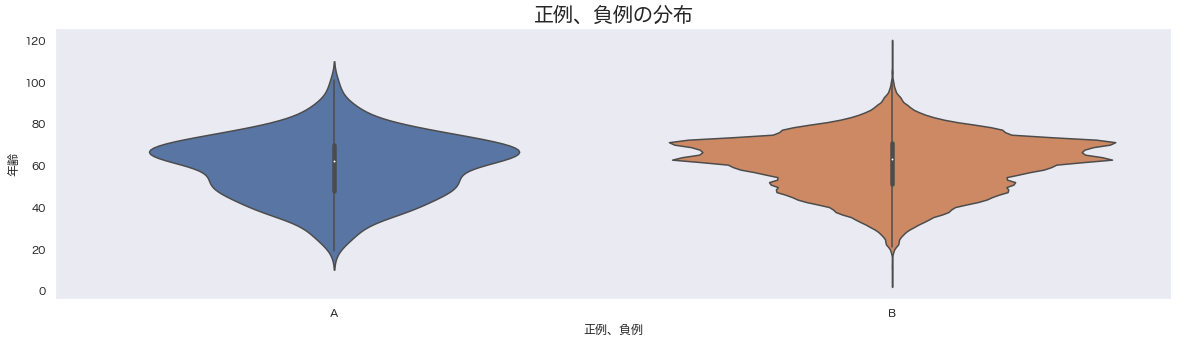

In [145]:
print('対象データ（対応のないデータと仮定）')
a = test[test['購入フラグ']==1]['年齢']
b = test[test['購入フラグ']==0]['年齢']
f_value, p_value = ftest(a, b)
print(f'F 統計量: {f_value}')
print(f'P 値: {p_value}');

有意水準を0.05、帰無仮説を「２群間の分散に差がないこと」とする。  
結果、p > 0.05 のため、帰無仮説は棄却されず、2群間の分散に差があると言えない。

## アンダーサンプリング、F検定

In [146]:
print("不均衡データのため、負例データのアンダー・サンプリングを実施")
from imblearn.under_sampling import RandomUnderSampler

target = '購入フラグ'
rs=RandomUnderSampler(random_state=42)
df_sample,_=rs.fit_resample(corr, corr[target])

print('*'*20)
print('＜元のデータ＞')
print('0の件数：%d'%len(test.query(f'{target}==0')))
print('1の件数：%d'%len(test.query(f'{target}==1')))
print('*'*20)
print('＜アンダーサンプリング後のデータ＞')
print('0の件数：%d'%len(df_sample.query(f'{target}==0')))
print('1の件数：%d'%len(df_sample.query(f'{target}==1')));

不均衡データのため、負例データのアンダー・サンプリングを実施
********************
＜元のデータ＞
0の件数：303918
1の件数：405
********************
＜アンダーサンプリング後のデータ＞
0の件数：405
1の件数：405


## シャピロ=ウィルク検定（正規性の検定）

In [147]:
from scipy import stats

ages1 = df_sample[df_sample['購入フラグ']==1]['年齢']
ages2 = df_sample[df_sample['購入フラグ']==0]['年齢']
print('検定')
stats.shapiro(ages1)
stats.shapiro(ages2);

検定


## F検定（アンダーサンプリング後）

対象データ（対応のないデータと仮定）
統計量Fの計算
帰無仮説が正しい場合にFが従う確率分を生成
両側検定
小さい方の2倍をp値とする
バイオリンプロット
統計量Fとp値
F 統計量: 1.22
P 値: 0.05


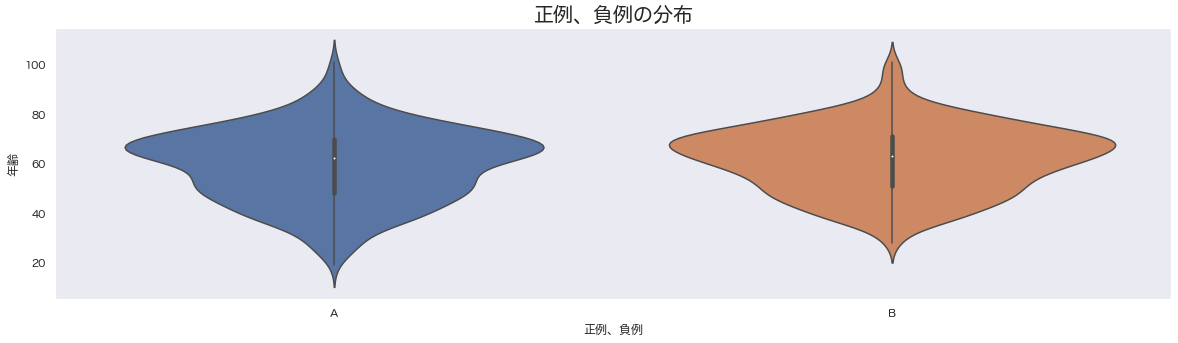

In [148]:
print('対象データ（対応のないデータと仮定）')
a = df_sample[df_sample['購入フラグ']==1]['年齢']
b = df_sample[df_sample['購入フラグ']==0]['年齢']
f_value, p_value = ftest(a, b)
print(f'F 統計量: {f_value}')
print(f'P 値: {p_value}');

## バートレット検定

In [149]:
# 正規分布
stats.bartlett(ages1, ages2)

BartlettResult(statistic=3.994847761808485, pvalue=0.04563957525672808)

## ルビーン検定

In [150]:
# 非正規分布
stats.levene(ages1, ages2) # 一応実施

LeveneResult(statistic=3.991155909497585, pvalue=0.046074488296894374)

## 考察

F検定（全量）  
F 統計量: 0.93  
P 値: 0.2  
→有意水準を0.05、帰無仮説を「２群間の分散に差がないこと」とする。  
→結果、p > 0.05 のため、帰無仮説は棄却されず、2群間の分散に差があると言えない。  
  
F検定（アンダーサンプリング後）  
F 統計量: 0.95  
P 値: 0.49  
→アンダーサンプリング後も棄却できない。  
  
バートレット検定  
pvalue=0.18  
→p > 0.05 のため、偶然ではない(有意)とは言えず、帰無仮説は棄却できない。  

  
ルビーン検定  
 pvalue=0.59  

# まとめ

元データだけでは説明力が弱い為、顧客情報、売上履歴から、新たに影響度の強い特徴量を作成する。  
特に、顧客住所、金額面に関する特徴量を作成する。  